## Problems/Challenges (w/ possible solns), To-do work
1. **Class Imbalance**

    **Data Level Techniques:**
    
      * Resampling Methods (oversampling minority, undersampling majority, hybrid sampling)
      
      * Data Augmentation (Image and Domain-specific augmentation)
    
   **Algo-level Techniques:**
    
      * Class Weights Adjustments (Weighted Loss fn, **Focal Loss**)
      * Ensemble Models (Balanced ensemble, Bayesian ensemble)
      
   **Uncertainty-specific techniques:**
   
     * Weighted Evidential Learning: 
       
      When dealing with class imbalance, it’s crucial to ensure that uncertainty is also appropriately calibrated. For instance, you can apply class-specific weights in the evidential deep learning loss function to make the model more sensitive to uncertainty in minority classes. This prevents the model from being overconfident in classifying underrepresented examples.

## Questions to be answered

* **Will data augmentation increase aleatoric uncertainty? If yes, then why augment data?**


If augmentations add realistic diversity, aleatoric uncertainty may not increase significantly. If augmentations introduce unrealistic or highly ambiguous data, it could increase aleatoric uncertainty.


## 1.  Import Libraries

In [1]:
import os
import numpy as np 
import pandas as pd 
import seaborn as sns
from glob import glob
import shutil
import random
from PIL import Image
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torchvision as tv
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
# from torchvision import models
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import torchvision.transforms as transforms
from torch.distributions import Dirichlet
from torch.distributions.kl import kl_divergence

import copy
import time
# import keras
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## 2. Loading data and merging images

In [4]:
base_dir = os.path.join('..', '/kaggle/input/skin-cancer-mnist-ham10000')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

image_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_dir, '*', '*.jpg'))}

# more friendly labels
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

### 2.1 Load and work with csv file

In [5]:
skin_df = pd.read_csv(os.path.join(base_dir, 'HAM10000_metadata.csv'))
skin_df.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


In [6]:
skin_df['path'] = skin_df['image_id'].map(image_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [8]:
skin_df.loc[0, 'path']

'/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0027419.jpg'

In [14]:
skin_df['cell_type_idx'].unique()

array([2, 4, 3, 5, 6, 1, 0], dtype=int8)

## 3. Orig/RESIZED IMG, andsome Hyperparameters

In [8]:
# SHAPE OF ORIGINAL IMAGES
np.asarray(Image.open(skin_df.loc[0, 'path'])).shape 

(450, 600, 3)

In [7]:
## RESIZED

# resized = 224
resized = 64
bs = 32 # Batch size

In [10]:
skin_df.tail(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
10005,HAM_0005579,ISIC_0028393,akiec,histo,80.0,male,face,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Actinic keratoses,0
10006,HAM_0004034,ISIC_0024948,akiec,histo,55.0,female,face,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Actinic keratoses,0
10007,HAM_0001565,ISIC_0028619,akiec,histo,60.0,female,face,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Actinic keratoses,0
10008,HAM_0001576,ISIC_0033705,akiec,histo,60.0,male,face,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Actinic keratoses,0
10009,HAM_0005705,ISIC_0031430,akiec,histo,75.0,female,lower extremity,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Actinic keratoses,0
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Actinic keratoses,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Actinic keratoses,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Actinic keratoses,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Actinic keratoses,0
10014,HAM_0003521,ISIC_0032258,mel,histo,70.0,female,back,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Melanoma,5


## 4. EDA

In [34]:
skin_df.isna().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
image            0
label            0
dtype: int64

In [7]:
skin_df['age'].fillna(skin_df['age'].mean(), inplace=True)

In [37]:
skin_df['dx'].value_counts()

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

<Axes: xlabel='cell_type'>

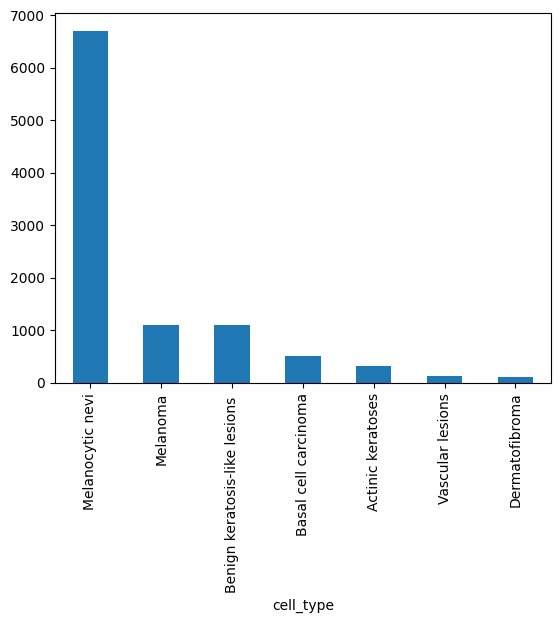

In [39]:
skin_df['cell_type'].value_counts().plot(kind='bar')

**There is a clear 'Class Imbalance' in this dataset!**

<Axes: xlabel='localization'>

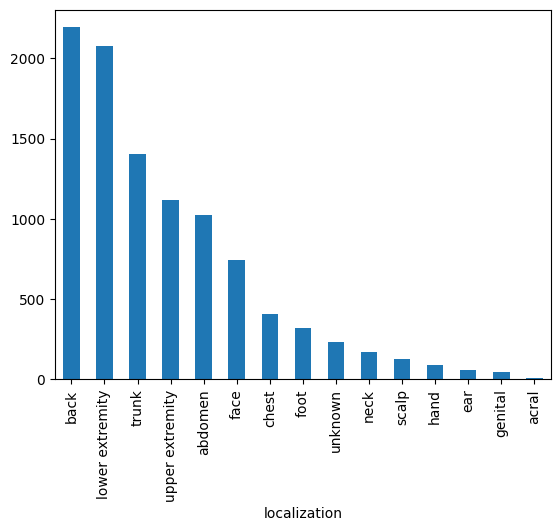

In [40]:
skin_df['localization'].value_counts().plot(kind='bar')

Plotting of Technical Validation field (ground truth), 'dx_type', to see the distribution of its 4 categories:
1. **Histopathology(Histo)**: Histopathologic diagnoses of excised lesions have been performed by specialized dermatopathologists.
2. **Confocal**: Reflectance confocal microscopy is an in-vivo imaging technique with a resolution at near-cellular level , and some facial benign with a grey-world assumption of all training-set images in Lab-color space before and after manual histogram changes.
3. **Follow-up**: If nevi monitored by digital dermatoscopy did not show any changes during 3 follow-up visits or 1.5 years biologists accepted this as evidence of biologic benignity. Only nevi, but no other benign diagnoses were labeled with this type of ground-truth because dermatologists usually do not monitor dermatofibromas, seborrheic keratoses, or vascular lesions.
4. **Consensus**: For typical benign cases without histopathology or followup biologists provide an expert-consensus rating of authors PT and HK. They applied the consensus label only if both authors independently gave the same unequivocal benign diagnosis. Lesions with this type of groundtruth were usually photographed for educational reasons and did not need further follow-up or biopsy for confirmation.

<Axes: xlabel='dx_type'>

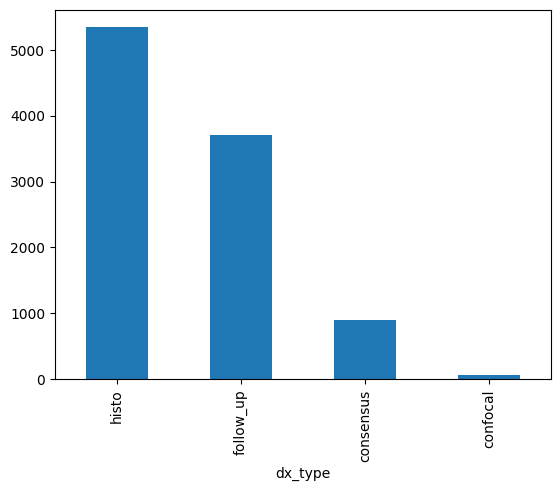

In [41]:
skin_df['dx_type'].value_counts().plot(kind='bar')

In [25]:
skin_df[skin_df['age'] == 0].shape

(39, 11)

In [12]:
skin_df[skin_df['age'] == 0]['dx']

117      bkl
118      bkl
865      bkl
866      bkl
902      bkl
2388    vasc
2389    vasc
2398    vasc
2399    vasc
6683      nv
6684      nv
6860      nv
6861      nv
7499      nv
7500      nv
8016      nv
8017      nv
9218      nv
9219      nv
9232      nv
9233      nv
9234      nv
9235      nv
9242      nv
9243      nv
9302      nv
9303      nv
9329      nv
9346      nv
9347      nv
9356      nv
9357      nv
9371      nv
9372      nv
9375      nv
9377      nv
9378      nv
9633      nv
9634      nv
Name: dx, dtype: object

Now this is a **dataset collection error (probably) where age is zero!** These above records may be dropped out if 'age' is also considered as a crucial factor in the task at hand or replaced by some value after analysis of data. Otherwise, only classification is the main task, then these values may be kept.

<Axes: xlabel='sex'>

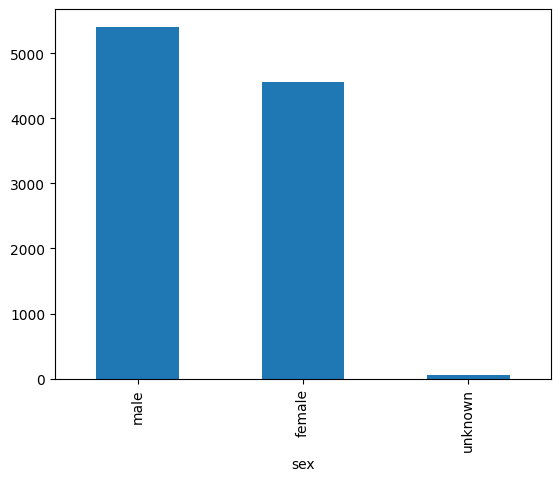

In [26]:
skin_df['sex'].value_counts().plot(kind='bar')

## 5. Preprocessing, Dataloaders & Mixup

In [19]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2


### 5.1 Dataframe with only images and labels

In [8]:
class_mapping = {label: idx for idx, label in enumerate(skin_df['dx'].unique())}
skin_df['label'] = skin_df['dx'].map(class_mapping)

In [10]:
class_mapping

{'bkl': 0, 'nv': 1, 'df': 2, 'mel': 3, 'vasc': 4, 'bcc': 5, 'akiec': 6}

In [9]:
df_img_label = skin_df[['path', 'label']]
df_img_label.head()

,path,label
0,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,0
1,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,0
2,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,0
3,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,0
4,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,0


**SPLIT data into 3 sets:**

In [10]:
# Splitting into Train, Validation and Test (70:15:15)
train_df, rem_df = train_test_split(df_img_label, test_size=0.3, 
                                    stratify=df_img_label['label'], random_state=42)
val_df, test_df = train_test_split(rem_df, test_size=0.5, stratify=rem_df['label'],
                                  random_state=42)

**Calculting Mean and Std for HAM10000 for normalization**

In [19]:
# # Mean and std channelwise??

# # Define a transform that only converts to tensor (without normalization)
# transform = v2.Compose([
#     v2.PILToTensor(),
#     v2.Resize(size=(resized, resized)), 
#     v2.ToDtype(torch.float32)
# ])

# # Load the dataset (ensure path_to_HAM10000 points to the dataset directory)
# temp_dataset = datasets.ImageFolder(root='/kaggle/working/data', transform=transform)
# temp_loader = DataLoader(temp_dataset, batch_size=64, shuffle=False)

# # Initialize sum and squared sum variables
# mean = torch.zeros(3)  # For 3 channels: R, G, B
# std = torch.zeros(3)
# num_pixels = 0

# # Calculate the mean and standard deviation for each channel
# for images, _ in temp_loader:
#     # Flatten each image to (batch_size, 3, H * W)
#     batch_pixels = images.size(0) * images.size(2) * images.size(3)
#     num_pixels += batch_pixels
    
#     # Sum of means across all batches
#     mean += images.mean([0, 2, 3]) * batch_pixels
#     std += images.std([0, 2, 3]) * batch_pixels

# # Final mean and std over all images
# mean /= num_pixels
# std /= num_pixels

# print("Mean:", mean)
# print("Std:", std)


Mean: tensor([194.7037, 139.2672, 145.4902])
Std: tensor([33.5904, 38.1428, 42.3377])


### 5.2 Transform, Custom Dataset and Dataloaders

In [11]:
# Mean and Std values are taken considering WHOLE DATASET
preproc = v2.Compose([
    v2.RandomHorizontalFlip(),
    v2.PILToTensor(),
    v2.Resize(size=(resized, resized)),  # Resize to 'resized'x'resized' Pixels 
    v2.ToDtype(torch.float32),  # to float32, Don't scale
    v2.Normalize(mean=(194.704, 139.267, 145.490), std=(33.590, 38.143, 42.338))  #cal. from HAM10K
])

In [12]:
# Custom Dataset
class SkinLesionDataset():
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['path']
        label = self.dataframe.iloc[idx]['label']
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [39]:
train_dataset = SkinLesionDataset(train_df, transform=preproc)
val_dataset = SkinLesionDataset(val_df, transform=preproc)
test_dataset = SkinLesionDataset(test_df, transform=preproc)

# DataLoaders
# bs = 32    ## instantiated above in Section 3
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

dataloaders = {
    "train": train_loader, "val": val_loader, "test": test_loader
}

In [13]:
# One-hot embedding function (explicit), if needed
def one_hot_embedding(labels, num_classes=10):
    y = torch.eye(num_classes).to(device)
    return y[labels]

### 5.3 Mixup Augmentation

In [14]:
# Hyperparameter
mixup_alpha = 1.0  # alpha (default 1.0) is hyperparameter of Beta dist.

In [19]:
# mixup = v2.MixUp(alpha=mixup_alpha, num_classes=7)  ## DIRTECT LIB USE

In [15]:
def mixup_data(x, y, alpha=mixup_alpha, num_classes=7, device=device):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    indices = list(range(batch_size))
    while True:
        random.shuffle(indices)
        # Check if the shuffled indices are a derangement
        if all(i != indices[i] for i in range(batch_size)):
            break
    
    indices = torch.tensor(indices).to(device)
    
    mixed_x = lam * x + (1 - lam) * x[indices, :]
    y_i, y_j = y, y[indices]
    y_i = F.one_hot(y_i, num_classes=num_classes)
    y_j = F.one_hot(y_j, num_classes=num_classes)
    
    return mixed_x, y_i, y_j, lam

## 6. Model Architectures, Loss functions and Optimizers
Try pretrained VGG, ResNet, EfficientNet etc. for classification

In [16]:
# ResNet18 architecture with EDL
class EDL_ResNet(nn.Module):
    def __init__(self, num_classes=7, pretrained=True):
        super(EDL_ResNet, self).__init__()
        
        # Load the pretrained ResNet18 model
        self.resnet = tv.models.resnet18(pretrained=pretrained)
        
        # Freeze initial layers
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Replace final fully connected layer with a new one for EDL
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
        self.softplus = nn.Softplus()  

    def forward(self, x):
        x = self.resnet(x)
        evidences = self.softplus(x)  # Convert to non-negative evidence
        return evidences

In [17]:
# Load ResNet50
resnet50 = tv.models.resnet50(pretrained=True)

# Load VGG16
vgg16 = tv.models.vgg16(pretrained=True)

# Load VGG19
# vgg19 = tv.models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 186MB/s]
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 220MB/s] 


In [18]:
def freeze_layers(model, num_layers_to_freeze):
    for i, child in enumerate(model.children()):
        if i < num_layers_to_freeze:
            for param in child.parameters():
                param.requires_grad = False

In [19]:
class EDL_model_based(nn.Module):
    def __init__(self, model, num_layers_to_freeze, num_classes=7, pretrained=True, 
                 evidence_scale=1.0):
        super(EDL_model_based, self).__init__()
        self.model = model
        self.evidence_scale = evidence_scale
        
        # Freeze initial layers
        freeze_layers(model, num_layers_to_freeze)
        
        # Replace final fully connected layer with a new one for EDL
        if model == resnet50:
            model.fc = nn.Linear(model.fc.in_features, num_classes)
        else:
            model.classifier[num_layers_to_freeze + 1] = nn.Linear(
                model.classifier[num_layers_to_freeze + 1].in_features, num_classes)

        self.softplus = nn.Softplus()  

    def forward(self, x):
        x = self.model(x)
        # Scale the evidence to better control uncertainty
        evidences = self.softplus(x) * self.evidence_scale
        return evidences

### KL Divergence and Digamma loss

In [20]:
# Digamma Loss with KL Divergence

# USING y_ij = y_i + y_j, labels here is a tuple
def KL_divergence(evidences, labels_list, is_mixup):
    alpha = evidences + 1           # Concentration Parameter (of Dirichlet) 
    if is_mixup:
        y_i, y_j = labels_list[0], labels_list[1]
    
        y_ij = (y_i + y_j).float()
        # If y_i and y_j are of SAME CLASS, then set y_ij to ONE-HOT ENCODED AGAIN
        equal_mask = (y_i == y_j).all(dim=1)
        for idx in range(equal_mask.size(0)):
            if equal_mask[idx]:
                y_ij[idx] /= 2
            
        y_ij = y_ij.to(torch.int64)
        
        alpha_tilde = y_ij + (1 - y_ij) * alpha    # MODIFIED ALPHA
        kl_term = kl_divergence(Dirichlet(alpha_tilde), Dirichlet(torch.ones_like(alpha)))
        kl_loss = torch.mean(kl_term)
    
        return kl_loss
    
    else:
        labels = labels_list[0]
        # ONE-HOT ENCODING OF LABELS 
        labels = F.one_hot(labels, num_classes=alpha.size(1))
        alpha_tilde = labels + (1 - labels) * alpha   # MODIFIED ALPHA
        kl_term = kl_divergence(Dirichlet(alpha_tilde), Dirichlet(torch.ones_like(alpha)))
        kl_loss = torch.mean(kl_term)
    
        return kl_loss

class edl_digamma_loss(nn.Module):
    def __init__(self, annealing_step=10, num_classes=7, name="digamma"):
        super(edl_digamma_loss, self).__init__()
        
        self.annealing_step = annealing_step
        self.num_classes = num_classes
        self.name = name
        
    def forward(self, evidences, label, labels_list, epoch_num, is_mixup=False):
        # label is either y_i or y_j and labels_list is list of these two
        if is_mixup:
            label_one_hot = label
        else:
            label_one_hot = F.one_hot(label, num_classes=self.num_classes).float()  ## index tensor error!!
        #     label_one_hot = one_hot_embedding(label, self.num_classes)
        
        alpha = evidences + 1
        S = torch.sum(alpha, dim=1, keepdim=True)
#         print("size of S", S.size())
        
        digamma_loss = torch.mean(torch.sum(label_one_hot * (torch.digamma(S) - torch.digamma(alpha)), dim=1))  # Loss eqn (4) of Vanilla-EDL
        
        annealing_coef = torch.min(                                        # kl_weight parameter
            torch.tensor(1.0, dtype=torch.float32),
            torch.tensor(epoch_num / self.annealing_step, dtype=torch.float32),
        )
        
        kl_loss = KL_divergence(evidences, labels_list, is_mixup)
        
        return digamma_loss + annealing_coef * kl_loss

### MSE loss function

In [21]:
class edl_mse_loss(nn.Module):
    def __init__(self, annealing_step=10, num_classes=7, name="mse"):
        super(edl_mse_loss, self).__init__()
        
        self.num_classes = num_classes
        self.annealing_step = annealing_step
        self.name = name

    def loglikelihood_loss(self, label_one_hot, alpha):
        label_one_hot = label_one_hot.to(device)
        alpha = alpha.to(device)
        S = torch.sum(alpha, dim=1, keepdim=True)
        loglikelihood_err = torch.sum((label_one_hot - (alpha / S)) ** 2, dim=1, keepdim=True)
        loglikelihood_var = torch.sum(alpha * (S - alpha) / (S * S * (S + 1)), dim=1, keepdim=True)
        loglikelihood = loglikelihood_err + loglikelihood_var
        return torch.mean(loglikelihood)

    def forward(self, evidences, label, labels_list, epoch_num, is_mixup=False):
        label = label.to(device)
        alpha = (evidences + 1).to(device)
        
        if is_mixup:
            label_one_hot = label
        else:
            label_one_hot = F.one_hot(label, num_classes=self.num_classes).float()  ## index tensor error!!
        #     label_one_hot = one_hot_embedding(label, self.num_classes)
        
        loglikelihood = self.loglikelihood_loss(label_one_hot, alpha)
        
        annealing_coef = torch.min(
            torch.tensor(1.0, dtype=torch.float32),
            torch.tensor(epoch_num / self.annealing_step, dtype=torch.float32)
        )

#         kl_alpha = (alpha - 1) * (1 - y) + 1
        kl_loss = KL_divergence(evidences, labels_list, is_mixup)
        
        return loglikelihood + annealing_coef * kl_loss

**Testing the working of code after getting y_ij and alpha_tilde**

one change made to y_ij -> dtype converted to float32 then converted back to int64

In [22]:
num_classes = 7  
annealing_step = 10

# Resnet50
edl_resnet50_model = EDL_model_based(resnet50, 7, num_classes=num_classes, pretrained=True)
edl_resnet50_model = edl_resnet50_model.to(device)

# VGG16
edl_VGG16_model = EDL_model_based(vgg16, 5, num_classes=num_classes, pretrained=True)
edl_VGG16_model = edl_VGG16_model.to(device)

# # VGG19
# edl_VGG19_model = EDL_model_based(vgg19, 5, num_classes=num_classes, pretrained=True)
# edl_VGG19_model = edl_VGG19_model.to(device)

# # Define loss and optimizer
# # criterion_digamma = edl_digamma_loss(annealing_step=annealing_step, num_classes=num_classes)   # If use Digamma loss
#                                          #OR
criterion_mse = edl_mse_loss(annealing_step=annealing_step, num_classes=num_classes)   # If use MSE loss

# # optimizer_resnet = torch.optim.Adam(filter(lambda p: p.requires_grad, edl_resnet_model.parameters()), lr=0.001)
optimizer_resnet50 = torch.optim.Adam(filter(lambda p: p.requires_grad, edl_resnet50_model.parameters()), lr=0.001)
optimizer_VGG16 = torch.optim.Adam(filter(lambda p: p.requires_grad, edl_VGG16_model.parameters()), lr=0.001)
# optimizer_VGG19 = torch.optim.Adam(filter(lambda p: p.requires_grad, edl_VGG19_model.parameters()), lr=0.001)

## 7. Training

### 7.1 Without mixup

**Classification based on logits**

In [30]:
# Train fn. # Set the NUMBER OF Epochs (hyperparam)
num_epochs = 30

def train_model(
    model,
    dataloaders,
    num_classes,
    criterion,
    optimizer,
    num_epochs=num_epochs,
    device=device,
    uncertainty=False,
):

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    losses = {"loss": [], "phase": [], "epoch": []}
    accuracy = {"accuracy": [], "phase": [], "epoch": []}
    evidences = {"evidence": [], "type": [], "epoch": []}

    for epoch in range(num_epochs):
        print("\nEpoch {}/{} :".format(epoch, num_epochs - 1))

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                print("'\033[1m' Training with {} loss...".format(criterion.name))
                model.train()  
            else:
                print("Validating...")
                model.eval()  

            running_loss = 0.0
            running_corrects = 0.0
            correct = 0

            # Iterate
            for i, (inputs, labels) in enumerate(dataloaders[phase]):

                inputs, labels = inputs.to(device), labels.to(device)
                labels_list = [labels]   # Not needed in case of NO Mixup, just optionally providing for digamma fn

                optimizer.zero_grad()

                # track train phase
                with torch.set_grad_enabled(phase == "train"):

                    if uncertainty:
                        evidences = model(inputs)
                        alpha = evidences + 1
                        S = torch.sum(alpha, dim=1, keepdim=True)   # Dirichlet Strength
                        
                        # Estimated probabilities and Predictions
                        est_probabilities = alpha/S  # <----------
                        _, preds = torch.max(evidences, 1)

                        # LOSS calculated using above defined LOSS function
#                         print("labels shape = ", labels.shape)
#                         print("alpha shape = ", alpha.shape)
                        loss = criterion.forward(evidences, labels, labels_list, epoch, is_mixup=False)

                        match = torch.reshape(torch.eq(preds, labels).float(), (-1, 1))  # preds == labels ?? -> One-hot encoded matching
                        acc = torch.mean(match)  
                        
                        # Uncertainty Calculation
                        u = num_classes / torch.sum(alpha, dim=1, keepdim=True)

#                         total_evidence = torch.sum(evidences, 1, keepdim=True)
#                         mean_evidence = torch.mean(total_evidence)
#                         mean_evidence_succ = torch.sum(
#                             torch.sum(evidences, 1, keepdim=True) * match
#                         ) / torch.sum(match + 1e-20)
#                         mean_evidence_fail = torch.sum(
#                             torch.sum(evidences, 1, keepdim=True) * (1 - match)
#                         ) / (torch.sum(torch.abs(1 - match)) + 1e-20)

                    else:
                        evidences = model(inputs)
                        S = torch.sum((evidences + 1), dim=1, keepdim=True)   
                        
                        # Estimated probabilities and Predictions
                        est_probabilities = (evidences + 1)/S  # <----------
                        _, preds = torch.max(evidences, 1)
                        
                        # LOSS calculated using above defined LOSS function
                        loss = criterion.forward(evidences, labels, labels_list, epoch, is_mixup=False)
                        
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # stats (don't forget to extract python number from torch.tensor in loss and accuracy)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            losses["loss"].append(epoch_loss)
            losses["phase"].append(phase)
            losses["epoch"].append(epoch)
            accuracy["accuracy"].append(epoch_acc.item())
            accuracy["epoch"].append(epoch)
            accuracy["phase"].append(phase)

            print(
                "{} loss: {:.4f} acc: {:.4f}".format(
                    phase.capitalize(), epoch_loss, epoch_acc
                )
            )
            
            print("-"*10)
            
            # deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            # Checkpoints after every 10 epochs
            if (epoch+1) < num_epochs and (epoch+1) % 10 == 0:
                checkpoints_edl_digamma = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "metrics": (losses, accuracy)
                }
                
                if model == edl_resnet_model:
                    torch.save(checkpoints_edl_digamma, "/kaggle/working/model_uncertainty_{}_EPOCH{}.pt".format(criterion.name, epoch))
                elif model == edl_resnet50_model:
                    torch.save(checkpoints_edl_digamma, "/kaggle/working/resnet50_uncertainty_{}_EPOCH{}.pt".format(criterion.name, epoch))
                elif model == edl_VGG16_model:
                    torch.save(checkpoints_edl_digamma, "/kaggle/working/VGG16_uncertainty_{}_EPOCH{}.pt".format(criterion.name, epoch))
                else:
                    torch.save(checkpoints_edl_digamma, "/kaggle/working/VGG19_uncertainty_{}_EPOCH{}.pt".format(criterion.name, epoch))

            


    time_elapsed = time.time() - since

    print(
        "\nTraining complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    
    print("Best val Acc: {:4f}".format(best_acc))
    
    # Save the losses and accuracy as metrics
    metrics = (losses, accuracy)
    
    # SAVE the Model
    state_edl_digamma = {
            "epochs": num_epochs,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "metrics": metrics
        }

    if model == edl_resnet_model:
        torch.save(state_edl_digamma, "/kaggle/working/model_uncertainty_{}.pt".format(criterion.name))
        print("Model edl_resnet_model Saved!")
    elif model == edl_resnet50_model:
        torch.save(state_edl_digamma, "/kaggle/working/resnet50_uncertainty_{}.pt".format(criterion.name))
        print("Model edl_resnet50_model Saved!")
    elif model == edl_VGG16_model:
        torch.save(state_edl_digamma, "/kaggle/working/VGG16_uncertainty_{}.pt".format(criterion.name))
        print("Model edl_VGG16_model Saved!")
    else:
        torch.save(state_edl_digamma, "/kaggle/working/VGG19_uncertainty_{}.pt".format(criterion.name))
        print("Model edl_VGG19_model Saved!")

    return model, metrics

### EDL with pre-trained ResNet50

In [36]:
## Digamma loss
# edl_digamma_resnet50_model,digamma_resnet50_metrics = train_model(edl_resnet50_model, dataloaders, num_classes, criterion_digamma, optimizer_resnet50, num_epochs, device, uncertainty=True)
                                                               
                                                                    ## OR
        
## MSE loss
# edl_mse_resnet50_model,mse_resnet50_metrics = train_model(edl_resnet50_model, dataloaders, num_classes, criterion_mse, optimizer_resnet50, num_epochs, device, uncertainty=True)


Epoch 0/29 :
'' Training with mse loss...
Train loss: 0.4127 acc: 0.7211
----------
Validating...
Val loss: 0.3500 acc: 0.7630
----------

Epoch 1/29 :
'' Training with mse loss...
Train loss: 0.4572 acc: 0.7603
----------
Validating...
Val loss: 0.4370 acc: 0.7603
----------

Epoch 2/29 :
'' Training with mse loss...
Train loss: 0.4485 acc: 0.7924
----------
Validating...
Val loss: 0.4670 acc: 0.7776
----------

Epoch 3/29 :
'' Training with mse loss...
Train loss: 0.4397 acc: 0.8123
----------
Validating...
Val loss: 0.5093 acc: 0.7803
----------

Epoch 4/29 :
'' Training with mse loss...
Train loss: 0.4202 acc: 0.8312
----------
Validating...
Val loss: 0.5138 acc: 0.7850
----------

Epoch 5/29 :
'' Training with mse loss...
Train loss: 0.4118 acc: 0.8405
----------
Validating...
Val loss: 0.5776 acc: 0.7949
----------

Epoch 6/29 :
'' Training with mse loss...
Train loss: 0.4065 acc: 0.8456
----------
Validating...
Val loss: 0.5907 acc: 0.7883
----------

Epoch 7/29 :
'' Training w

### Training EDL with pre-trained VGG16

In [39]:
# ## Digamma loss
# # edl_digamma_VGG16_model,digamma_VGG16_metrics = train_model(edl_VGG16_model, dataloaders, num_classes, criterion_digamma, optimizer_VGG16, num_epochs, device, uncertainty=True)
                                                               
#                                                                     ## OR
        
# ## MSE loss
# edl_mse_VGG16_model,mse_VGG16_metrics = train_model(edl_VGG16_model, dataloaders, num_classes, criterion_mse, optimizer_VGG16, num_epochs, device, uncertainty=True)


Epoch 0/29 :
'' Training with mse loss...
Train loss: 0.4640 acc: 0.6863
----------
Validating...
Val loss: 0.4176 acc: 0.7057
----------

Epoch 1/29 :
'' Training with mse loss...
Train loss: 0.5606 acc: 0.7136
----------
Validating...
Val loss: 0.5230 acc: 0.7290
----------

Epoch 2/29 :
'' Training with mse loss...
Train loss: 0.5783 acc: 0.7244
----------
Validating...
Val loss: 0.5688 acc: 0.7317
----------

Epoch 3/29 :
'' Training with mse loss...
Train loss: 0.6099 acc: 0.7257
----------
Validating...
Val loss: 0.5910 acc: 0.7237
----------

Epoch 4/29 :
'' Training with mse loss...
Train loss: 0.6349 acc: 0.7285
----------
Validating...
Val loss: 0.6290 acc: 0.7277
----------

Epoch 5/29 :
'' Training with mse loss...
Train loss: 0.6575 acc: 0.7258
----------
Validating...
Val loss: 0.6330 acc: 0.7290
----------

Epoch 6/29 :
'' Training with mse loss...
Train loss: 0.6666 acc: 0.7205
----------
Validating...
Val loss: 0.6535 acc: 0.7304
----------

Epoch 7/29 :
'' Training w

### Training EDL with pre-trained VGG19

In [40]:
# ## Digamma loss
# # edl_digamma_VGG19_model,digamma_VGG19_metrics = train_model(edl_VGG19_model, dataloaders, num_classes, criterion_digamma, optimizer_VGG19, num_epochs, device, uncertainty=True)
                                                               
#                                                                     ## OR
        
# ## MSE loss
# edl_mse_VGG19_model,mse_VGG19_metrics = train_model(edl_VGG19_model, dataloaders, num_classes, criterion_mse, optimizer_VGG19, num_epochs, device, uncertainty=True)


Epoch 0/29 :
'' Training with mse loss...
Train loss: 0.4705 acc: 0.6896
----------
Validating...
Val loss: 0.4177 acc: 0.6997
----------

Epoch 1/29 :
'' Training with mse loss...
Train loss: 0.5691 acc: 0.7111
----------
Validating...
Val loss: 0.5297 acc: 0.7117
----------

Epoch 2/29 :
'' Training with mse loss...
Train loss: 0.5952 acc: 0.7170
----------
Validating...
Val loss: 0.5788 acc: 0.7190
----------

Epoch 3/29 :
'' Training with mse loss...
Train loss: 0.6212 acc: 0.7188
----------
Validating...
Val loss: 0.5964 acc: 0.7190
----------

Epoch 4/29 :
'' Training with mse loss...
Train loss: 0.6437 acc: 0.7185
----------
Validating...
Val loss: 0.6191 acc: 0.7077
----------

Epoch 5/29 :
'' Training with mse loss...
Train loss: 0.6675 acc: 0.7133
----------
Validating...
Val loss: 0.6355 acc: 0.7071
----------

Epoch 6/29 :
'' Training with mse loss...
Train loss: 0.6810 acc: 0.7133
----------
Validating...
Val loss: 0.6456 acc: 0.7130
----------

Epoch 7/29 :
'' Training w

### 7.2 Training with mixup
* Loss function and Regularizer are modified because of mixup technique

In [23]:
def mixup_criterion(criterion, evidences, y_i, y_j, lam, epoch_num):
    labels_list = [y_i, y_j]
    return lam * criterion.forward(evidences, y_i, labels_list, epoch_num, is_mixup=True) \
            + (1 - lam) * criterion.forward(evidences, y_j, labels_list, epoch_num, is_mixup=True)

In [24]:
# Train with Mixup....# SET no. of Epochs (Hyper Param)
num_epochs = 30       

In [25]:
def train_model_mixup(
    model,
    dataloaders,
    num_classes,
    criterion,             
    optimizer,
    mixup_alpha=mixup_alpha,
    num_epochs=num_epochs,
    device=device,
    scheduler=None,
    uncertainty=False,
    logits=True,
    is_focal=False,
    is_resnet50=True
):
    
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc_mixup = 0.0
    losses = {"loss": [], "phase": [], "epoch": []}
    accuracy = {"accuracy": [], "phase": [], "epoch": []}
    evidences = {"evidence": [], "type": [], "epoch": []}

    for epoch in range(num_epochs):
        print("\nEpoch {}/{} :".format(epoch+1, num_epochs))
        
        # ===== ADAPTIVE LOSS WEIGHTING =============
        # Adjust weights only when using focal loss
        if is_focal and hasattr(criterion, 'focal_weight') and hasattr(criterion, 'edl_weight'):
            # Early epochs: Focus more on classification
            if epoch < num_epochs // 3:
                criterion.focal_weight = 0.7
                criterion.edl_weight = 0.3
                print(f"\nAdaptive weights: Focal={criterion.focal_weight:.1f}, EDL={criterion.edl_weight:.1f}\n")
            # Middle epochs: Balance both objectives  
            elif epoch < 2 * num_epochs // 3:
                criterion.focal_weight = 0.5
                criterion.edl_weight = 0.5
                print(f"\nAdaptive weights: Focal={criterion.focal_weight:.1f}, EDL={criterion.edl_weight:.1f}\n")
            # Later epochs: Focus more on uncertainty calibration
            else:
                criterion.focal_weight = 0.3
                criterion.edl_weight = 0.7
                print(f"\nAdaptive weights: Focal={criterion.focal_weight:.1f}, EDL={criterion.edl_weight:.1f}\n")
        # ====================================================

        for phase in ["train", "val"]:
            if phase == "train":
                print("'\033[1m' Training using {} loss...".format(criterion.name))
                model.train()  
            else:
                print("Validating...")
                model.eval()  

            running_loss = 0.0
            running_corrects = 0.0
            correct = 0

            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Perform augmentation on data
                inputs, labels_i, labels_j, lam = mixup_data(inputs, labels, mixup_alpha, num_classes, device)
                inputs, labels_i, labels_j = map(Variable, (inputs, labels_i, labels_j))
                
                optimizer.zero_grad()

                # track train phase
                with torch.set_grad_enabled(phase == "train"):

                    if uncertainty:
                        evidences = model(inputs)
                        alpha = evidences + 1
                        S = torch.sum(alpha, dim=1, keepdim=True)   # Dirichlet Strength
                        
                        # Estimated probabilities and Predictions
                        est_probabilities = alpha/S  # <--------------------------------
                        outputs = [evidences, est_probabilities]
                        if logits:
                            _, preds = torch.max(outputs[0], 1) #<-----LOGITS USED
                        else:
                            _, preds = torch.max(outputs[1], 1) #<-----Est_prob. Used

                
               
                        if is_focal and hasattr(criterion, 'focal_weight'):
                            # Use the focal-specific mixup criterion
                            loss = mixup_criterion_focal(criterion, evidences, labels_i, labels_j, lam, epoch+1)
                        else:
                            # Use the original mixup criterion for standard EDL losses
                            loss = mixup_criterion(criterion, evidences, labels_i, labels_j, lam, epoch+1)

                        labels_i_class = torch.argmax(labels_i, dim=1)
                        labels_j_class = torch.argmax(labels_j)
#                         if epoch == 0 and correct ==0:             ## to check shapes
#                             print("labels_i_class", labels_i_class)
                        correct += (lam * preds.eq(labels_i_class).cpu().sum().float() \
                                    + (1 - lam) * preds.eq(labels_j_class).cpu().sum().float())
                        running_corrects += correct
#                         acc = currect/labels.size(0)
        
                        # Uncertainty Calculation
                        u = num_classes / torch.sum(alpha, dim=1, keepdim=True)

#                         total_evidence = torch.sum(evidences, 1, keepdim=True)
#                         mean_evidence = torch.mean(total_evidence)
#                         mean_evidence_succ = torch.sum(
#                             torch.sum(evidences, 1, keepdim=True) * match
#                         ) / torch.sum(match + 1e-20)
#                         mean_evidence_fail = torch.sum(
#                             torch.sum(evidences, 1, keepdim=True) * (1 - match)
#                         ) / (torch.sum(torch.abs(1 - match)) + 1e-20)

                    else:
                        evidences = model(inputs)
                        S = torch.sum((evidences + 1), dim=1, keepdim=True)   

                        _, preds = torch.max(evidences, 1)
                        
                        # running corrects
                        labels_i_class = torch.argmax(labels_i, dim=1)
                        labels_j_class = torch.argmax(labels_j, dim=1)
                        correct += (lam * preds.eq(labels_i_class).cpu().sum().float() \
                                    + (1 - lam) * preds.eq(labels_j_class).cpu().sum().float())
                        running_corrects += correct
                        
                        # LOSS calculated using above defined LOSS function
                        loss = mixup_criterion(criterion, evidences, labels_i, labels_j, lam, epoch)

                
                    if phase == "train":
                        loss.backward()
                    
                        # Add gradient clipping for stability
                        if is_focal:
                            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                        
                        optimizer.step()

                # stats (don't forget to extract python number from torch.tensor in loss and accuracy)
                running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            losses["loss"].append(epoch_loss)
            losses["phase"].append(phase)
            losses["epoch"].append(epoch)
            accuracy["accuracy"].append(epoch_acc.item())
            accuracy["epoch"].append(epoch)
            accuracy["phase"].append(phase)

            print(
                "{} loss: {:.4f} acc: {:.4f}".format(
                    phase.capitalize(), epoch_loss, epoch_acc
                )
            )
            
            print("-"*10)
            
            # deep copy the model
            if phase == "val" and epoch_acc > best_acc_mixup:
                best_acc_mixup = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            # Checkpoints after every 10 epochs
            if (epoch) < num_epochs and (epoch+1) % 10 == 0:
                checkpoints_edl_digamma = {
                "epoch": epoch+1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "metrics": (losses, accuracy)
                }
                
                if not is_focal:
                    if model == edl_resnet50_model:
                        torch.save(checkpoints_edl_digamma, "/kaggle/working/resnet50_uncertainty_{}_MIXUP_EPOCH{}.pt".format(criterion.name, epoch+1))
                    elif model == edl_VGG16_model:
                        torch.save(checkpoints_edl_digamma, "/kaggle/working/VGG16_uncertainty_{}_MIXUP_EPOCH{}.pt".format(criterion.name, epoch+1))
                    else:
                        torch.save(checkpoints_edl_digamma, "/kaggle/working/VGG19_uncertainty_{}_MIXUP_EPOCH{}.pt".format(criterion.name, epoch+1))
                
                else:  # edl_resnet50_model_focal, metrics_resnet50_focal
                    if is_resnet50:
                        torch.save(checkpoints_edl_digamma, "/kaggle/working/edl_resnet50_focal_uncertainty_{}_MIXUP_EPOCH{}.pt".format(criterion.name, epoch+1))
                    else:
                        torch.save(checkpoints_edl_digamma, "/kaggle/working/edl_vgg16_focal_uncertainty_{}_MIXUP_EPOCH{}.pt".format(criterion.name, epoch+1))
        
            # Step scheduler after each epoch
            if phase == "val":
                if scheduler is not None:
                    scheduler.step(epoch_loss)
                    print(f"\nLearning rate: {scheduler.get_last_lr()[0]:.6f}\n")
            
    time_elapsed = time.time() - since

    print(
        "\nTraining complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    
    print("Best val Acc (Mixup): {:4f}".format(best_acc_mixup))
    
    # Save the losses and accuracy as metrics
    metrics = (losses, accuracy)
    
    # SAVE the Model
    state_edl_digamma = {
            "epochs": num_epochs,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "metrics": metrics
        }

    if not is_focal:
        if model == edl_resnet50_model:
            torch.save(state_edl_digamma, "/kaggle/working/resnet50_uncertainty_{}_MIXUP.pt".format(criterion.name))
            print("Model edl_resnet50_model Saved!")
        elif model == edl_VGG16_model:
            torch.save(state_edl_digamma, "/kaggle/working/VGG16_uncertainty_{}_MIXUP.pt".format(criterion.name))
            print("Model edl_VGG16_model Saved!")
        else:
            torch.save(state_edl_digamma, "/kaggle/working/VGG19_uncertainty_{}_MIXUP.pt".format(criterion.name))
            print("Model edl_VGG19_model Saved!")

    else:
        if is_resnet50:
            torch.save(state_edl_digamma, "/kaggle/working/edl_resnet50_focal_uncertainty_{}_MIXUP.pt".format(criterion.name))
            print("Model edl_resnet50_model_focal Saved!")
        else:
            torch.save(state_edl_digamma, "/kaggle/working/edl_vgg16_focal_uncertainty_{}_MIXUP.pt".format(criterion.name))
            print("Model edl_vgg16_model_focal Saved!")
    
    return model, metrics

### Training with mixup and Resnet50

**Logits for classification**

In [46]:
## Digamma loss
# edl_digamma_resnet50_model_mixup,digamma_resnet50_metrics_mixup = train_model_mixup(edl_resnet50_model, dataloaders, num_classes, criterion_digamma, optimizer_resnet50, mixup_alpha, num_epochs, device, uncertainty=True, logits=True)
                                                               
                                                                    ## OR
        
## MSE loss
edl_mse_resnet50_model_mixup,mse_resnet50_metrics_mixup = train_model_mixup(edl_resnet50_model, dataloaders, num_classes, criterion_mse, optimizer_resnet50, mixup_alpha, num_epochs, device, uncertainty=True, logits=True)


Epoch 0/29 :
'' Training using mse loss...
Train loss: 0.3481 acc: 72.8747
----------
Validating...
Val loss: 0.4471 acc: 16.5094
----------

Epoch 1/29 :
'' Training using mse loss...
Train loss: 0.3806 acc: 73.6154
----------
Validating...
Val loss: 0.4892 acc: 15.6128
----------

Epoch 2/29 :
'' Training using mse loss...
Train loss: 0.3771 acc: 74.3617
----------
Validating...
Val loss: 0.5421 acc: 16.2509
----------

Epoch 3/29 :
'' Training using mse loss...
Train loss: 0.3794 acc: 74.4025
----------
Validating...
Val loss: 0.5342 acc: 15.7694
----------

Epoch 4/29 :
'' Training using mse loss...
Train loss: 0.3830 acc: 76.3192
----------
Validating...
Val loss: 0.5573 acc: 15.4540
----------

Epoch 5/29 :
'' Training using mse loss...
Train loss: 0.4058 acc: 76.5804
----------
Validating...
Val loss: 0.5897 acc: 14.0901
----------

Epoch 6/29 :
'' Training using mse loss...
Train loss: 0.4048 acc: 75.8479
----------
Validating...
Val loss: 0.6092 acc: 13.7474
----------

Epoch

**Probability estimates for classification**

In [ ]:
## Digamma loss
# edl_digamma_resnet50_model_mixup2,digamma_resnet50_metrics_mixup2 = train_model_mixup(edl_resnet50_model, dataloaders, num_classes, criterion_digamma, optimizer_resnet50, mixup_alpha, num_epochs, device, uncertainty=True, logits=False)
                                                               
                                                                    ## OR
        
## MSE loss
# edl_mse_resnet50_model_mixup2,mse_resnet50_metrics_mixup2 = train_model_mixup(edl_resnet50_model, dataloaders, num_classes, criterion_mse, optimizer_resnet50, mixup_alpha, num_epochs, device, uncertainty=True, logits=False)

### Training With mixup and VGG16

**Logits are used for class predictions:**

In [ ]:
## Digamma loss
# edl_digamma_VGG16_model_mixup,digamma_metrics_VGG16_mixup = train_model_mixup(edl_VGG16_model, dataloaders, num_classes, criterion_digamma, optimizer_VGG16, mixup_alpha, num_epochs, device, uncertainty=True, logits=True, is_focal=False, is_resnet50=False)
    
                                                                    ## OR
## MSE loss
# edl_mse_VGG16_model_mixup,mse_metrics_VGG16_mixup = train_model_mixup(edl_VGG16_model, dataloaders, num_classes, criterion_mse, optimizer_VGG16, mixup_alpha, num_epochs, device, uncertainty=True, logits=True, is_focal=False, is_resnet50=False)

* **Instead of logits, estimated probabilities are used to predict class (not uncertainty)**

In [ ]:
## Digamma loss
# edl_digamma_VGG16_model_mixup2,digamma_metrics_VGG16_mixup2 = train_model_mixup(edl_VGG16_model, dataloaders, num_classes, criterion_digamma, optimizer_VGG16, mixup_alpha, num_epochs, device, uncertainty=True, logits=False, is_focal=False, is_resnet50=False)
    
                                                                    ## OR
## MSE loss
# edl_mse_VGG16_model_mixup2,mse_metrics_VGG16_mixup2 = train_model_mixup(edl_VGG16_model, dataloaders, num_classes, criterion_mse, optimizer_VGG16, mixup_alpha, num_epochs, device, uncertainty=True, logits=False, is_focal=False, is_resnet50=False)

### Training With mixup and VGG19

**classification using logits**

In [ ]:
## Digamma loss
# edl_digamma_VGG19_model_mixup,digamma_metrics_VGG19_mixup = train_model_mixup(edl_VGG19_model, dataloaders, num_classes, criterion_digamma, optimizer_VGG19, mixup_alpha, num_epochs, device, uncertainty=True, logits=True)
    
                                                                    ## OR
## MSE loss
# edl_mse_VGG19_model_mixup,mse_metrics_VGG19_mixup = train_model_mixup(edl_VGG19_model, dataloaders, num_classes, criterion_mse, optimizer_VGG19, mixup_alpha, num_epochs, device, uncertainty=True, logits=True)

**classification using estimated probabilities**


In [ ]:
## Digamma loss
# edl_digamma_VGG19_model_mixup2,digamma_metrics_VGG19_mixup2 = train_model_mixup(edl_VGG19_model, dataloaders, num_classes, criterion_digamma, optimizer_VGG19, mixup_alpha, num_epochs, device, uncertainty=True, logits=False)
    
                                                                    ## OR
## MSE loss
# edl_mse_VGG19_model_mixup2,mse_metrics_VGG19_mixup2 = train_model_mixup(edl_VGG19_model, dataloaders, num_classes, criterion_mse, optimizer_VGG19, mixup_alpha, num_epochs, device, uncertainty=True, logits=False)

## 8. Loading Saved model(s)

### 8.1 ResNet50

In [26]:
# # LOAD Resnet50 (Without mixup and mse loss) model 
# checkpoint = torch.load("/kaggle/input/resnet50_mse/pytorch/default/1/resnet50_uncertainty_mse.pt", map_location = torch.device(device))
# edl_resnet50_model.load_state_dict(checkpoint["model_state_dict"])  # Load the final saved model
# optimizer_resnet50.load_state_dict(checkpoint["optimizer_state_dict"])

### 8.2 VGG16

In [27]:
# # LOAD VGG16 (Without mixup and digamma loss) model 
# checkpoint_vgg16 = torch.load("/kaggle/input/vgg16_digamma/pytorch/default/1/VGG16_uncertainty_digamma.pt", map_location = torch.device(device))
# edl_VGG16_model.load_state_dict(checkpoint_vgg16["model_state_dict"])  # Load the final saved model
# optimizer_VGG16.load_state_dict(checkpoint_vgg16["optimizer_state_dict"])

### 8.3 Resnet50 + Mixup + mse loss (Load Only When Evaluating/Testing With Mixup Case)

In [27]:
# Load Resnet50 (WITH Mixup and mse loss)
checkpoint_mixup = torch.load("/kaggle/input/resnet50_mse_mixup/pytorch/default/1/resnet50_uncertainty_mse_MIXUP.pt", map_location = torch.device(device))
edl_resnet50_model.load_state_dict(checkpoint_mixup["model_state_dict"])  # Load the final saved model
optimizer_resnet50.load_state_dict(checkpoint_mixup["optimizer_state_dict"])

### 8.4 VGG16 + Mixup + Digamma loss (Load Only When Evaluating/Testing mixup case)

In [29]:
# LOAD VGG16 (With mixup and digamma loss) model 
checkpoint_vgg16_mixup = torch.load("/kaggle/input/vgg16_digamma/pytorch/default/1/VGG16_uncertainty_digamma.pt", map_location = torch.device(device))
edl_VGG16_model.load_state_dict(checkpoint_vgg16_mixup["model_state_dict"])  # Load the final saved model
optimizer_VGG16.load_state_dict(checkpoint_vgg16_mixup["optimizer_state_dict"])

## 9. Test the models

In [27]:
for i in range(2):
    images, labels = next(iter(test_loader))
    
    random_idx = random.randint(0, images.size(0) - 1)
    single_image = images[random_idx]  # Select a single image
    single_label = labels[random_idx]
    
    single_image = single_image.to(device).unsqueeze(0)  # Add batch dimension for single image
    print(f"\nSample Image {i+1} - \n")
    print("Original image shape:\n", single_image.shape)
    
    edl_resnet50_model.eval()
    with torch.no_grad():
            evidence = edl_resnet50_model(single_image)
            alpha = evidence + 1
            uncertainty = num_classes / torch.sum(alpha, dim=1, keepdim=True)
            _, preds = torch.max(evidence, 1)
            prob = alpha / torch.sum(alpha, dim=1, keepdim=True)   # Estimated Class Probabilities
            evidence = evidence.flatten()
            prob = prob.flatten()
            preds = preds.flatten()
            print("\n \033[1m Probs:", prob)
            print("\n \033[1m Prediction:", preds[0])
            print("\033[1m  Ground truth:", single_label)       
            print("\n \033[1m Uncertainty estimate:", uncertainty, "\033[0m")
    print("."*100)
    print()


Sample Image 1 - 

Original image shape:
 torch.Size([1, 3, 64, 64])

  Probs: tensor([0.0040, 0.9758, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040],
       device='cuda:0')

  Prediction: tensor(1, device='cuda:0')
  Ground truth: tensor(1)

  Uncertainty estimate: tensor([[0.0283]], device='cuda:0') 
....................................................................................................


Sample Image 2 - 

Original image shape:
 torch.Size([1, 3, 64, 64])

  Probs: tensor([0.1498, 0.1421, 0.1417, 0.1416, 0.1416, 0.1416, 0.1416],
       device='cuda:0')

  Prediction: tensor(0, device='cuda:0')
  Ground truth: tensor(0)

  Uncertainty estimate: tensor([[0.9914]], device='cuda:0') 
....................................................................................................



In [30]:
def test_single_image(model, test_loader, uncertainty=True, is_mixup=False, device=device):
    images, labels = next(iter(test_loader))
    
    random_idx = random.randint(0, images.size(0) - 1)
    single_image = images[random_idx]  # Select a single image
    single_label = labels[random_idx]
    
    single_image = single_image.to(device).unsqueeze(0)  # Add batch dimension for single image
    
    lesion_types = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
    print("\033[1m Lesion Types: ", lesion_types, "\033[0m")
    
    print("\nOriginal image shape:\n", single_image.shape)
    
    model.eval()
    with torch.no_grad():
        if uncertainty:
            evidence = model(single_image)
            alpha = evidence + 1
            uncertainty = num_classes / torch.sum(alpha, dim=1, keepdim=True)
            _, preds = torch.max(evidence, 1)
            prob = alpha / torch.sum(alpha, dim=1, keepdim=True)   # Estimated Class Probabilities
            evidence = evidence.flatten()
            prob = prob.flatten()
            preds = preds.flatten()
            print("\n \033[1m Probs:", prob)
            print("\n \033[1m Prediction: ", preds[0])
            print("\033[1m  Ground truth:", single_label)       
            print("\n \033[1m Uncertainty estimate:", uncertainty, "\033[0m \n")
    
        else:
            output = model(single_image)
            _, preds = torch.max(output, 1)
            prob = F.softmax(output, dim=1)
            output = output.flatten()
            prob = prob.flatten()
            preds = preds.flatten()
            print("\n \033[1m Probs:", prob)
            print("\n \033[1m Prediction:", preds[0])
            print("\033[1m  Ground truth:", single_label) 
            print()

        labels = np.arange(7)
        fig = plt.figure(figsize=[7, 5])
        fig, axs = plt.subplots(1, 2, gridspec_kw={"width_ratios": [1, 3]})

        plt.title("Classified as: {}, Ground truth: {}, Uncertainty: {}".format(preds[0], single_label.squeeze(dim=0), uncertainty.item()))

        axs[0].set_title("Image")
        axs[0].imshow(single_image.cpu().squeeze().permute(1, 2, 0).numpy(), cmap="gray")
        axs[0].axis("off")

        axs[1].bar(labels, prob.cpu().detach().numpy(), width=0.5)
        axs[1].set_xlim([0, 9])
        axs[1].set_ylim([0, 1])
        axs[1].set_xticks(np.arange(7))
        axs[1].set_xlabel("Classes")
        axs[1].set_ylabel("Classification Probability")

        fig.tight_layout()

        if is_mixup:
            plt.savefig("/kaggle/working/test_img_random{}_mixup".format(random_idx))
        else:
            plt.savefig("/kaggle/working/test_img_random{}".format(random_idx))

### **(ReNnet50 + mse)**

 Lesion Types:  ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'] 

Original image shape:
 torch.Size([1, 3, 64, 64])

  Probs: tensor([0.0112, 0.9329, 0.0112, 0.0112, 0.0112, 0.0112, 0.0112],
       device='cuda:0')

  Prediction:  tensor(1, device='cuda:0')
  Ground truth: tensor(1)

  Uncertainty estimate: tensor([[0.0783]], device='cuda:0')  



<Figure size 700x500 with 0 Axes>

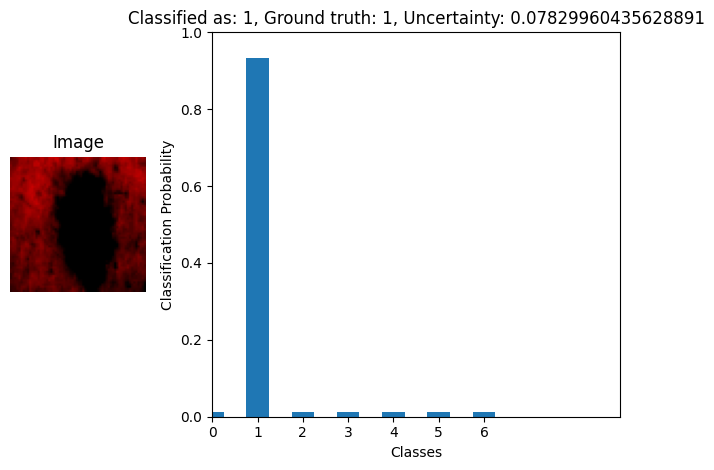

In [34]:
test_single_image(edl_resnet50_model, test_loader, uncertainty=True, is_mixup=False)

### **(ResNet50 + mixup + mse)**

 Lesion Types:  ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'] 

Original image shape:
 torch.Size([1, 3, 64, 64])

  Probs: tensor([0.0131, 0.9214, 0.0131, 0.0131, 0.0131, 0.0131, 0.0131],
       device='cuda:0')

  Prediction:  tensor(1, device='cuda:0')
  Ground truth: tensor(1)

  Uncertainty estimate: tensor([[0.0918]], device='cuda:0')  



<Figure size 700x500 with 0 Axes>

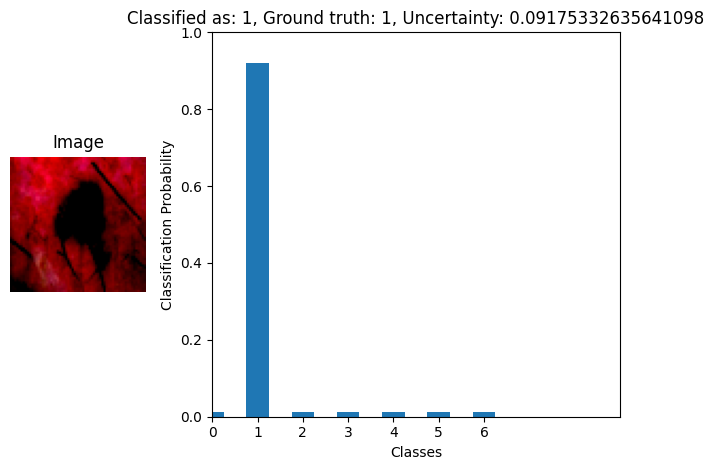

In [29]:
test_single_image(edl_resnet50_model, test_loader, uncertainty=True, is_mixup=True)

### **(VGG16 + Digamma)**

 Lesion Types:  ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'] 

Original image shape:
 torch.Size([1, 3, 64, 64])

  Probs: tensor([0.0210, 0.8737, 0.0210, 0.0210, 0.0210, 0.0210, 0.0210])

  Prediction:  tensor(1)
  Ground truth: tensor(1)

  Uncertainty estimate: tensor([[0.1473]])  



<Figure size 700x500 with 0 Axes>

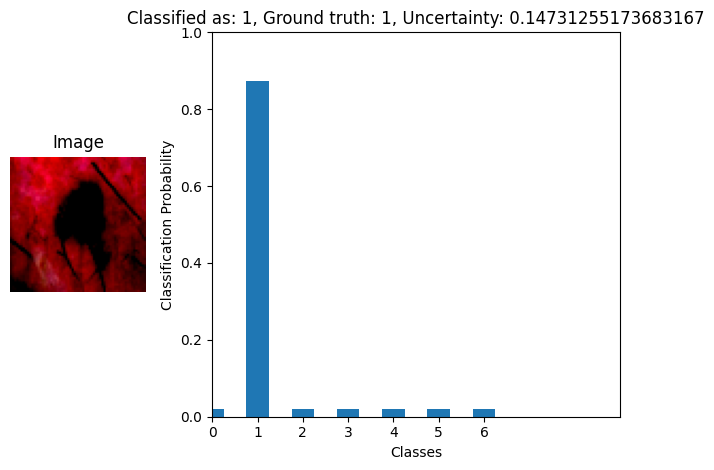

In [32]:
test_single_image(edl_VGG16_model, test_loader, uncertainty=True, is_mixup=False)

### **(VGG16 + Digamma + mixup)**

In [35]:
# Load VGG16 (WITH Mixup and Digamma loss)
checkpoint_VGG16_mixup = torch.load("/kaggle/input/vgg16_digamma_mixup/pytorch/default/1/VGG16_uncertainty_digamma_MIXUP.pt", map_location = torch.device(device))
edl_VGG16_model.load_state_dict(checkpoint_VGG16_mixup["model_state_dict"])  # Load the final saved model
optimizer_VGG16.load_state_dict(checkpoint_VGG16_mixup["optimizer_state_dict"])

/tmp/ipykernel_30/2689777051.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_VGG16_mixup = torch.load("/kaggle/input/vgg16_digamma_mixup/pytorch/default/1/VGG

 Lesion Types:  ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'] 

Original image shape:
 torch.Size([1, 3, 64, 64])

  Probs: tensor([0.0730, 0.5550, 0.0730, 0.0730, 0.0799, 0.0730, 0.0730])

  Prediction:  tensor(1)
  Ground truth: tensor(1)

  Uncertainty estimate: tensor([[0.5112]])  



<Figure size 700x500 with 0 Axes>

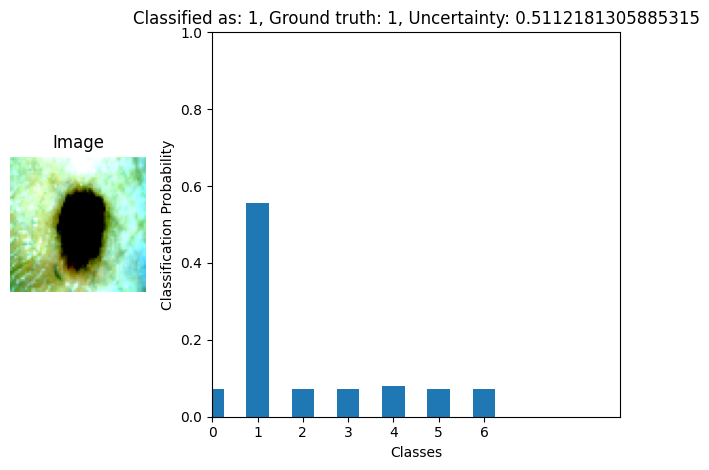

In [40]:
test_single_image(edl_VGG16_model, test_loader, uncertainty=True, is_mixup=True)

## 10. **Model metrics**

### **10.1 AUC Scores**

In [31]:
def auc_metric(model, test_loader, num_classes=num_classes, device=device):
    model.eval()  # Set model to evaluation mode

    all_labels, all_probs = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
        
            evidences = model(inputs)
            alpha = evidences + 1
            u = num_classes/torch.sum(alpha, dim=1, keepdim=True)
            est_probs = alpha/torch.sum(alpha, dim=1, keepdim=True)  
            all_probs.append(est_probs.cpu())  
        
            all_labels.append(labels.cpu())

    # Concatenate all predictions and labels
    all_probs = torch.cat(all_probs)
    all_labels = torch.cat(all_labels)

    if all_probs.size(1) == 2:  # Binary case
        auc = roc_auc_score(all_labels, all_probs[:, 1])  
    else:
        # For multiclass, calculate the AUC for each class and average
        auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')

    print(f"\033[1m AUC of loaded model: {auc:.4f} \033[0m")

### **AUC on Resnet50 (without mixup + mse)**

In [27]:
auc_metric(edl_resnet50_model, test_loader)

 AUC of loaded model: 0.8959


### **AUC metric on ResNet50 (mixup augmented + mse)**

In [ ]:
# # Load Resnet50 (WITH Mixup and mse loss)
# checkpoint_mixup = torch.load("/kaggle/input/resnet50_mse_mixup/pytorch/default/1/resnet50_uncertainty_mse_MIXUP.pt", map_location = torch.device(device))
# edl_resnet50_model.load_state_dict(checkpoint_mixup["model_state_dict"])  # Load the final saved model
# optimizer_resnet50.load_state_dict(checkpoint_mixup["optimizer_state_dict"])

**Higher AUC score is expected for misclassification identification in uncertainty measure-driven applications.**

**Class Balanced EDL paper evaluated AUC = 0.854 on skin lesion screening.**

In [30]:
auc_metric(edl_resnet50_model, test_loader)

 AUC of loaded model: 0.9080


**That's a very good AUC score!!**

### **AUC on VGG16 (without mixup + digamma)**

In [60]:
# # LOAD VGG16 (Without mixup and digamma loss) model 
# checkpoint_vgg16 = torch.load("/kaggle/input/vgg16_digamma/pytorch/default/1/VGG16_uncertainty_digamma.pt", map_location = torch.device(device))
# edl_VGG16_model.load_state_dict(checkpoint_vgg16["model_state_dict"])  # Load the final saved model
# optimizer_VGG16.load_state_dict(checkpoint_vgg16["optimizer_state_dict"])

/tmp/ipykernel_30/3383857680.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_vgg16 = torch.load("/kaggle/input/vgg16_digamma/pytorch/default/1/VGG16_uncertain

In [35]:
auc_metric(edl_VGG16_model, test_loader)

 AUC of loaded model: 0.8314 


### **AUC metric on VGG16 (mixup augmented + digamma)**

In [37]:
# Load VGG16 (WITH Mixup and Digamma loss)
checkpoint_VGG16_mixup = torch.load("/kaggle/input/vgg16_digamma_mixup/pytorch/default/1/VGG16_uncertainty_digamma_MIXUP.pt", map_location = torch.device(device))
edl_VGG16_model.load_state_dict(checkpoint_VGG16_mixup["model_state_dict"])  # Load the final saved model
optimizer_VGG16.load_state_dict(checkpoint_VGG16_mixup["optimizer_state_dict"])

/tmp/ipykernel_30/1323229673.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_VGG16_mixup = torch.load("/kaggle/input/vgg16_digamma_mixup/pytorch/default/1/VGG

In [38]:
auc_metric(edl_VGG16_model, test_loader)

 AUC of loaded model: 0.8290 


### **Brier, Recall, and ECE**

**Recall (Rec):** Measures the model's ability to find all relevant cases.

* Particularly important in medical diagnostics where missing a positive case can be critical
  
* Calculated as: TP / (TP + FN) where TP = True Positives, FN = False Negatives
For multi-class, it's typically macro-averaged across all classes


**Brier Score:** Measures both discrimination and calibration of probabilistic predictions

* Calculated as mean squared error between predicted probabilities and actual outcomes
  
* Range: 0 to 1 (lower is better)

* Particularly useful for EDL as it evaluates the quality of uncertainty estimates
Formula: 1/N * Σ(p_i - y_i)² where p_i is predicted probability and y_i is true label


**Expected Calibration Error (ECE):** Measures how well the model's confidence matches its actual accuracy

* Calculated by:
* * Grouping predictions into bins based on confidence
    
* * For each bin, calculating |accuracy - confidence|
    
* * Taking weighted average across bins
    
* * Range: 0 to 1 (lower is better)
    
* * Important for EDL as it shows if uncertainty estimates are reliable

In [32]:
from sklearn.metrics import recall_score

In [33]:
class UncertaintyMetrics:
    def __init__(self, num_bins=10):
        self.num_bins = num_bins
    
    def calculate_recall(self, y_true, y_pred):
        """
        Recall (Rec): Measures the ability to find all relevant cases within a dataset
        For multi-class: Macro-averaged recall across all classes
        """
        return recall_score(y_true, y_pred, average='macro')

    def calculate_brier_score(self, y_true_one_hot, probabilities):
        """
        Brier Score: Measures both discrimination and calibration
        Computed as mean squared error between predicted probabilities and one-hot encoded true labels
        Lower values indicate better probabilistic predictions
        """
        return np.mean(np.sum((probabilities - y_true_one_hot) ** 2, axis=1))

    def calculate_ece(self, probabilities, y_true, predictions):
        """
        Expected Calibration Error (ECE): Measures reliability of uncertainty estimates
        Computed by binning predictions by confidence and comparing to actual accuracy
        Lower values indicate better calibrated uncertainties
        """
        confidences = np.max(probabilities, axis=1)
        
        # Create bins
        bins = np.linspace(0., 1., self.num_bins + 1)
        bins[-1] = 1.0001  # Ensure the highest confidence prediction is included
        
        ece = 0.0
        for i in range(self.num_bins):
            # Find predictions in current confidence bin
            bin_mask = (confidences >= bins[i]) & (confidences < bins[i + 1])
            if not any(bin_mask):
                continue
                
            bin_confidence = confidences[bin_mask]
            bin_accuracy = (predictions[bin_mask] == y_true[bin_mask])
            
            # Calculate average confidence and accuracy for bin
            avg_confidence = np.mean(bin_confidence)
            avg_accuracy = np.mean(bin_accuracy)
            
            # Weight by proportion of samples in bin
            bin_weight = len(bin_confidence) / len(confidences)
            
            # Add weighted calibration error
            ece += bin_weight * np.abs(avg_confidence - avg_accuracy)
            
        return ece

In [34]:
def evaluate_edl_model(model, test_loader, device, num_classes):
    """
    Evaluate EDL model using all three metrics
    """
    model.eval()
    metrics = UncertaintyMetrics()
    
    all_probs = []
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Get model predictions
            evidences = model(inputs)
            alpha = evidences + 1
            S = torch.sum(alpha, dim=1, keepdim=True)
            
            # Calculate probabilities from EDL outputs
            probs = alpha / S
            predictions = torch.argmax(probs, dim=1)
            
            # Store results
            all_probs.append(probs.cpu().numpy())
            all_preds.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    # Concatenate all batches
    all_probs = np.concatenate(all_probs)
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    
    # Convert labels to one-hot encoding for Brier score
    y_true_one_hot = F.one_hot(torch.tensor(all_labels), num_classes=num_classes).numpy()
    
    # Calculate all metrics
    recall = metrics.calculate_recall(all_labels, all_preds)
    brier = metrics.calculate_brier_score(y_true_one_hot, all_probs)
    ece = metrics.calculate_ece(all_probs, all_labels, all_preds)
    
    return {
        'Recall': recall,
        'Brier Score': brier,
        'ECE': ece,
        'probabilities': all_probs,
        'predictions': all_preds,
        'labels': all_labels
    }

In [36]:
# Visualization of calibration
def plot_calibration_curve(probabilities, y_true, predictions, num_bins=10):
    """
    Plot reliability diagram showing model calibration
    """
    import matplotlib.pyplot as plt
    
    confidences = np.max(probabilities, axis=1)
    bins = np.linspace(0., 1., num_bins + 1)
    
    bin_confidences = []
    bin_accuracies = []
    
    for i in range(num_bins):
        bin_mask = (confidences >= bins[i]) & (confidences < bins[i + 1])
        if any(bin_mask):
            bin_confidence = np.mean(confidences[bin_mask])
            bin_accuracy = np.mean(predictions[bin_mask] == y_true[bin_mask])
            
            bin_confidences.append(bin_confidence)
            bin_accuracies.append(bin_accuracy)
    
    plt.figure(figsize=(8, 8))
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
    plt.plot(bin_confidences, bin_accuracies, 'ro-', label='Model Calibration')
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.title('Reliability Diagram')
    plt.legend()
    plt.grid(True)
    plt.savefig("Reliability_diagram_showing_model_calibration.png")
    plt.show()


In [35]:
def evaluate_and_report(model, test_loader, device, num_classes):
    """
    Evaluate model and report metrics, including calibration plot
    """
    results = evaluate_edl_model(model, test_loader, device, num_classes)
    
    print("\nModel Evaluation Metrics:")
    print(f"Recall (Rec): {results['Recall']:.4f}")
    print(f"Brier Score: {results['Brier Score']:.4f}")
    print(f"Expected Calibration Error (ECE): {results['ECE']:.4f}")
    
    # Plot calibration curve
    plot_calibration_curve(
        results['probabilities'],
        results['labels'],
        results['predictions']
    )
    
    return results

#### **For Resnet50 EDL model**


Model Evaluation Metrics:
Recall (Rec): 0.5957
Brier Score: 0.3090
Expected Calibration Error (ECE): 0.0720


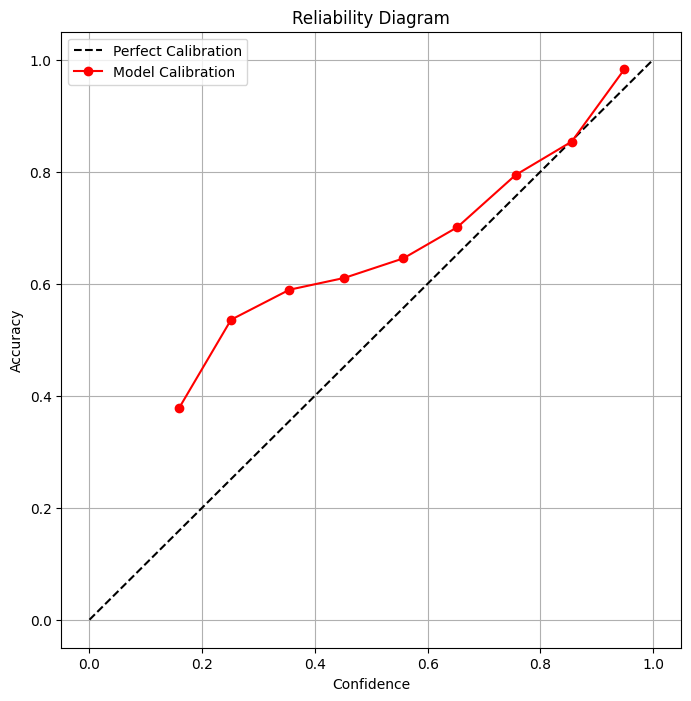

In [40]:
# Evaluate model
U_metrics = evaluate_and_report(edl_resnet50_model, test_loader, device, num_classes=7)

In [ ]:
# plot_calibration_curve(U_metrics['probabilities'], U_metrics['labels'], U_metrics['predictions'], num_bins=10)

#### **For VGG16 EDL model**


Model Evaluation Metrics:
Recall (Rec): 0.3906
Brier Score: 0.4681
Expected Calibration Error (ECE): 0.2531


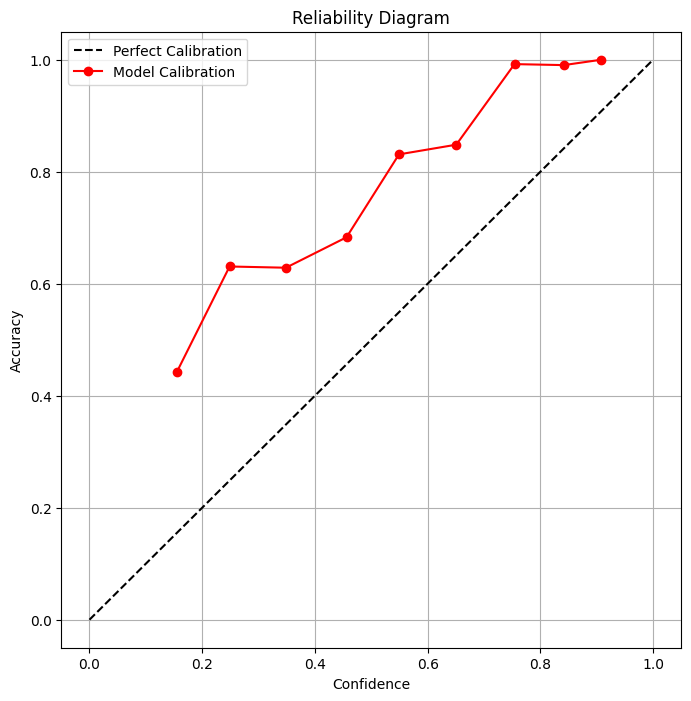

In [41]:
# Evaluate model
U_metrics_vgg = evaluate_and_report(edl_VGG16_model, test_loader, device, num_classes=7)

### **10.2 Uncertainty Confusion metric**

**Use an "*uncertainty threshold*" to decide whether a prediction be called as uncertain or not**

In [39]:
def uncertainty_confusion_metric(model, test_loader, num_classes=num_classes, device=device):
    # store all uncertainty scores and predictions
    uncertainty_scores = []
    all_preds, all_labels = [], []
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            evidences = model(inputs)
            alpha = evidences + 1
            uncertainty = num_classes / torch.sum(alpha, dim=1, keepdim=True) 
            
            preds = torch.argmax(evidences, dim=1).cpu()
            uncertainty = uncertainty.cpu()
            labels = labels.cpu()
            
            # Append results
            uncertainty_scores.append(uncertainty)
            all_preds.append(preds)
            all_labels.append(labels)

    # Concatenate all stored results
    uncertainty_scores = torch.cat(uncertainty_scores)
    uncertainty_scores = uncertainty_scores.squeeze(dim=1)  # From [32, 1] to [32] tensor
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    print("\033[1mUncertainty scores:", uncertainty_scores, "\033[0m")
    print("Uncertainty scores shape:", uncertainty_scores.shape)
    print("all_preds shape:", all_preds.shape)
    print("all_labels shape:", all_labels.shape)
    print("-"*100)
    

    # Define an uncertainty threshold (e.g., median or fixed like 0.5)               # <---------------- THRESHOLDS
    thresholds = [torch.mean(uncertainty_scores).item(), torch.median(uncertainty_scores).item(), 0.2, 0.25, 0.35]  
    for i, threshold in enumerate(thresholds):
        if i==0:
            print("\n\033[1mUncertainty threshold (mean of uncertainty_scores) is:", threshold)
            print(f"i.e., when Model is at least {(1-threshold)*100}% confident:\033[0m\n")
        elif i==1:
            print("\n\033[1mUncertainty threshold (median of uncertainty_scores) is:", threshold)
            print(f"i.e., when Model is at least {(1-threshold)*100}% confident:\033[0m\n")
        else:
            print("\n\033[1mUncertainty threshold is:", threshold)
            print(f"i.e., when Model is at least {(1-threshold)*100}% confident:\033[0m\n")
    
        # CC:Correct&Certain, IC:Incorrect&Certain, CU:Correct&Uncertain, IU:Incorrect&Uncertain
        CC, IC, CU, IU = 0, 0, 0, 0
    
        for pred, label, uncertainty in zip(all_preds, all_labels, uncertainty_scores):
            # Set criterias for metrics
            correct = pred == label
            high_uncertainty = uncertainty > threshold             ## <---------- Determining Step
        
            if correct and not high_uncertainty:
                CC += 1
            elif not correct and not high_uncertainty:
                IC += 1
            elif correct and high_uncertainty:
                CU += 1
            elif not correct and high_uncertainty:
                IU += 1
    
        # Uncertainty Confusion matrix
        uncertainty_conf_matrix = torch.tensor([[CC, IC], [CU, IU]])
    
        print("\033[1mUncertainty Confusion Matrix:")
        print("[[CC, IC],")
        print("[CU, IU]]\n")
        print(uncertainty_conf_matrix)
        print("*"*100)

    # Return the uncertainty scores, predictions, and corresponding ground truths (needed in further analysis)
    return uncertainty_scores, all_preds, all_labels

#### **10.2.1 (Resnet50 + mse)**

In [44]:
resnet50_uncertainty_scores, resnet50_preds, resnet50_labels = uncertainty_confusion_metric(edl_resnet50_model, test_loader)

Uncertainty scores: tensor([0.9958, 0.2934, 0.9980,  ..., 0.0978, 0.0631, 0.9915]) 
Uncertainty scores shape: torch.Size([1503])
all_preds shape: torch.Size([1503])
all_labels shape: torch.Size([1503])
----------------------------------------------------------------------------------------------------

Uncertainty threshold (mean of uncertainty_scores) is: 0.2919670045375824
i.e., when Model is at least 70.80329954624176% confident:

Uncertainty Confusion Matrix:
[[CC, IC],
[CU, IU]]

tensor([[944,  80],
        [255, 224]])
****************************************************************************************************

Uncertainty threshold (median of uncertainty_scores) is: 0.125285342335701
i.e., when Model is at least 87.4714657664299% confident:

Uncertainty Confusion Matrix:
[[CC, IC],
[CU, IU]]

tensor([[723,  29],
        [476, 275]])
****************************************************************************************************

Uncertainty threshold is: 0.2
i.e., wh

**IN CASE WHEN THRESHOLD == MEAN:**

* **Approximately 61.4% of the test data is Correct and Certain.** 
* **Next prefered category in this metric is IU (Incorrect and Uncertain), which is ~15% of the test data.** 
* **Third preference in this metric should be given to CU (Correct and Uncertain), which is ~18.3% of  the test data.** 
* **And rest is least prefered, Incorrect and Certain, contains ~5.4% of the test data.**
* **It's noteworthy that most preferred category has highest no. of samples and least preferred category has least no. of samples from test data!**

**IN CASE WHEN THRESHOLD == MEDIAN:**

* **Approximately 48% of the test data is Correct and Certain.** 
* **Next prefered category in this metric is IU (Incorrect and Uncertain), which is ~18.3% of the test data.** 
* **Third preference in this metric should be given to CU (Correct and Uncertain), which is ~31.66% of  the test data.** 
* **And rest is least prefered, Incorrect and Certain, contains ~2% of the test data.**
* **It's noteworthy that most preferred category has highest no. of samples and least preferred category has least no. of samples from test data!**

**IN CASE WHEN THRESHOLD == 0.2:**

* **Approximately 56% of the test data is Correct and Certain.** 
* **Next prefered category in this metric is IU (Incorrect and Uncertain), which is ~17% of the test data.** 
* **Third preference in this metric should be given to CU (Correct and Uncertain), which is ~23.7% of  the test data.** 
* **And rest is least prefered, Incorrect and Certain, contains ~3.32% of the test data.**
* **It's noteworthy that most preferred category has highest no. of samples and least preferred category has least no. of samples from test data!**

**IN CASE WHEN THRESHOLD == 0.25:**

* **Approximately 58.5% of the test data is Correct and Certain.** 
* **Next prefered category in this metric is IU (Incorrect and Uncertain), which is ~16% of the test data.** 
* **Third preference in this metric should be given to CU (Correct and Uncertain), which is ~21.16% of  the test data.** 
* **And rest is least prefered, Incorrect and Certain, contains ~4.3% of the test data.**
* **It's noteworthy that most preferred category has highest no. of samples and least preferred category has least no. of samples from test data!**

**IN CASE WHEN THRESHOLD == 0.35:**

* **Approximately 63.73% of the test data is Correct and Certain.** 
* **Next prefered category in this metric is IU (Incorrect and Uncertain), which is ~14.44% of the test data.** 
* **Third preference in this metric should be given to CU (Correct and Uncertain), which is ~16% of  the test data.** 
* **And rest is least prefered, Incorrect and Certain, contains ~5.85% of the test data.**
* **It's noteworthy that most preferred category has highest no. of samples and least preferred category has least no. of samples from test data!**

#### **10.2.2 (Resnet50 + mixup + mse)**

In [57]:
resnet50_mixup_uncertainty_scores, resnet50_mixup_preds, resnet50_mixup_labels = uncertainty_confusion_metric(edl_resnet50_model, test_loader)

Uncertainty scores: tensor([0.9666, 0.2075, 0.8233,  ..., 0.0704, 0.0883, 0.4804]) 
Uncertainty scores shape: torch.Size([1503])
all_preds shape: torch.Size([1503])
all_labels shape: torch.Size([1503])
----------------------------------------------------------------------------------------------------

Uncertainty threshold (mean of uncertainty_scores) is: 0.3042313754558563
i.e., when Model is at least 69.57686245441437% confident:

Uncertainty Confusion Matrix:
[[CC, IC],
[CU, IU]]

tensor([[903,  54],
        [304, 242]])
****************************************************************************************************

Uncertainty threshold (median of uncertainty_scores) is: 0.164532870054245
i.e., when Model is at least 83.5467129945755% confident:

Uncertainty Confusion Matrix:
[[CC, IC],
[CU, IU]]

tensor([[736,  16],
        [471, 280]])
****************************************************************************************************

Uncertainty threshold is: 0.2
i.e., wh

**IN CASE WHEN THRESHOLD == MEAN:**

* **Approximately 59% of the test data is Correct and Certain.** 
* **Next prefered category in this metric is IU (Incorrect and Uncertain), which is ~16.3% of the test data.** 
* **Third preference in this metric should be given to CU (Correct and Uncertain), which is ~21% of  the test data.** 
* **And rest is least prefered, Incorrect and Certain, contains ~3.66% of the test data.**
* **It's noteworthy that most preferred category has highest no. of samples and least preferred category has least no. of samples from test data!**
*  **Uncertainty Acc. = 0.7532 (= CC+IU/total)**
*  **Correct Certain Ratio = 0.6267 (best value closer to one)**

**IN CASE WHEN THRESHOLD == MEDIAN:**

* **Approximately 48.64% of the test data is Correct and Certain.** 
* **Next prefered category in this metric is IU (Incorrect and Uncertain), which is ~18.56% of the test data.** 
* **Third preference in this metric should be given to CU (Correct and Uncertain), which is ~31.4% of  the test data.** 
* **And rest is least prefered, Incorrect and Certain, contains ~1.4% of the test data.**
* **It's noteworthy that most preferred category has highest no. of samples and least preferred category has least no. of samples from test data!**
*  **Uncertainty Acc. = 0.672**
*  **Correct Certain Ratio = 0.5**

**IN CASE WHEN THRESHOLD == 0.2:**

* **Approximately 51.3% of the test data is Correct and Certain.** 
* **Next prefered category in this metric is IU (Incorrect and Uncertain), which is ~17.83% of the test data.** 
* **Third preference in this metric should be given to CU (Correct and Uncertain), which is ~28.64% of  the test data.** 
* **And rest is least prefered, Incorrect and Certain, contains ~2.13% of the test data.**
* **It's noteworthy that most preferred category has highest no. of samples and least preferred category has least no. of samples from test data!**
*  **Uncertainty Acc. = 0.69**
*  **Correct Certain Ratio = 0.534**

**IN CASE WHEN THRESHOLD == 0.25:**

* **Approximately 54.9% of the test data is Correct and Certain.** 
* **Next prefered category in this metric is IU (Incorrect and Uncertain), which is ~17.23% of the test data.** 
* **Third preference in this metric should be given to CU (Correct and Uncertain), which is ~25.15% of  the test data.** 
* **And rest is least prefered, Incorrect and Certain, contains ~2.73% of the test data.**
* **It's noteworthy that most preferred category has highest no. of samples and least preferred category has least no. of samples from test data!**
*  **Uncertainty Acc. = 0.72**
*  **Correct Certain Ratio = 0.576**

#### **(VGG16 + Digamma)**

In [36]:
VGG16_uncertainty_scores, VGG16_preds, VGG16_labels = uncertainty_confusion_metric(edl_VGG16_model, test_loader)

Uncertainty scores: tensor([0.9992, 0.9975, 0.5828,  ..., 0.2257, 0.3941, 0.5033]) 
Uncertainty scores shape: torch.Size([1503])
all_preds shape: torch.Size([1503])
all_labels shape: torch.Size([1503])
----------------------------------------------------------------------------------------------------

Uncertainty threshold (mean of uncertainty_scores) is: 0.6009742617607117
i.e., when Model is at least 39.90257382392883% confident:

Uncertainty Confusion Matrix:
[[CC, IC],
[CU, IU]]

tensor([[720,  63],
        [388, 332]])
****************************************************************************************************

Uncertainty threshold (median of uncertainty_scores) is: 0.5784565210342407
i.e., when Model is at least 42.15434789657593% confident:

Uncertainty Confusion Matrix:
[[CC, IC],
[CU, IU]]

tensor([[696,  56],
        [412, 339]])
****************************************************************************************************

Uncertainty threshold is: 0.2
i.e., 

**IN CASE WHEN THRESHOLD == MEAN:**

* **Approximately 47.9% of the test data is Correct and Certain.** 
* **Next prefered category in this metric is IU (Incorrect and Uncertain), which is ~22% of the test data.** 
* **Third preference in this metric should be given to CU (Correct and Uncertain), which is ~25.82% of  the test data.** 
* **And rest is least prefered, Incorrect and Certain, contains ~4.19% of the test data.**
* **It's noteworthy that most preferred category has highest no. of samples and least preferred category has least no. of samples from test data!**
*  **Uncertainty Acc. = 0.7(= CC+IU/total)**
*  **Correct Certain Ratio = 0.52 (best value closer to one)**

**IN CASE WHEN THRESHOLD == MEDIAN:**

* **Approximately 46.31% of the test data is Correct and Certain.** 
* **Next prefered category in this metric is IU (Incorrect and Uncertain), which is ~22.55% of the test data.** 
* **Third preference in this metric should be given to CU (Correct and Uncertain), which is ~27.41% of  the test data.** 
* **And rest is least prefered, Incorrect and Certain, contains ~3.73% of the test data.**
* **It's noteworthy that most preferred category has highest no. of samples and least preferred category has least no. of samples from test data!**
*  **Uncertainty Acc. = 0.6886 (= CC+IU/total)**
*  **Correct Certain Ratio = 0.50 (best value closer to one)**

**IN CASE WHEN THRESHOLD == 0.2:**

* **Approximately 8.45% of the test data is Correct and Certain.** 
* **Next prefered category in this metric is IU (Incorrect and Uncertain), which is ~26.21% of the test data.** 
* **Third preference in this metric should be given to CU (Correct and Uncertain), which is ~65.27% of  the test data.** 
* **And rest is least prefered, Incorrect and Certain, contains ~0.07% of the test data.**
* **Now in this case of VGG16, with at least 80% model confidence expected, CC test samples are less than IU and even CU, where CU samples being the most. So this model should be used if we want at least 80% confidence.**
*  **Uncertainty Acc. = 0.3466 (= CC+IU/total)**
*  **Correct Certain Ratio = 0.852 (best value closer to one)**

**IN CASE WHEN THRESHOLD == 0.25:**

* **Approximately 16.57% of the test data is Correct and Certain.** 
* **Next prefered category in this metric is IU (Incorrect and Uncertain), which is ~26.21% of the test data.** 
* **Third preference in this metric should be given to CU (Correct and Uncertain), which is ~57.15% of  the test data.** 
* **And rest is least prefered, Incorrect and Certain, contains ~0.07% of the test data.**
* **Even if model confidence is reduced to at least 75%, results and conclusion is similar to >=80% model.**
*  **Uncertainty Acc. = 0.4278 (= CC+IU/total)**
*  **Correct Certain Ratio = 0.1663 (best value closer to one)**

#### **(VGG16 + Digamma + mixup)**

In [39]:
VGG16_mixup_uncertainty_scores, VGG16_mixup_preds, VGG16_mixup_labels = uncertainty_confusion_metric(edl_VGG16_model, test_loader)

Uncertainty scores: tensor([0.9999, 0.5983, 0.6380,  ..., 0.2046, 0.3010, 0.7700]) 
Uncertainty scores shape: torch.Size([1503])
all_preds shape: torch.Size([1503])
all_labels shape: torch.Size([1503])
----------------------------------------------------------------------------------------------------

Uncertainty threshold (mean of uncertainty_scores) is: 0.4965655505657196
i.e., when Model is at least 50.34344494342804% confident:

Uncertainty Confusion Matrix:
[[CC, IC],
[CU, IU]]

tensor([[794, 110],
        [293, 306]])
****************************************************************************************************

Uncertainty threshold (median of uncertainty_scores) is: 0.3957834541797638
i.e., when Model is at least 60.42165458202362% confident:

Uncertainty Confusion Matrix:
[[CC, IC],
[CU, IU]]

tensor([[695,  57],
        [392, 359]])
****************************************************************************************************

Uncertainty threshold is: 0.2
i.e., 

**IN CASE WHEN THRESHOLD == MEAN:**

* **Approximately 52.83% of the test data is Correct and Certain.** 
* **Next prefered category in this metric is IU (Incorrect and Uncertain), which is ~20.36% of the test data.** 
* **Third preference in this metric should be given to CU (Correct and Uncertain), which is ~19.49% of  the test data.** 
* **And rest is least prefered, Incorrect and Certain, contains ~7.32% of the test data.**
* **It's noteworthy that most preferred category has highest no. of samples and least preferred category has least no. of samples from test data!**
*  **Uncertainty Acc. = 0.7319 (= CC+IU/total)**
*  **Correct Certain Ratio = 0.6015 (best value closer to one)**

**IN CASE WHEN THRESHOLD == MEDIAN:**

* **Approximately 46.24% of the test data is Correct and Certain.** 
* **Next prefered category in this metric is IU (Incorrect and Uncertain), which is ~23.89% of the test data.** 
* **Third preference in this metric should be given to CU (Correct and Uncertain), which is ~26.08% of  the test data.** 
* **And rest is least prefered, Incorrect and Certain, contains ~3.79% of the test data.**
* **It's noteworthy that most preferred category has highest no. of samples and least preferred category has least no. of samples from test data!**
*  **Uncertainty Acc. = 0.7013 (= CC+IU/total)**
*  **Correct Certain Ratio = 0.50 (best value closer to one)**

**IN CASE WHEN THRESHOLD == 0.2:**

* **Approximately 16.03% of the test data is Correct and Certain.** 
* **Next prefered category in this metric is IU (Incorrect and Uncertain), which is ~27.61% of the test data.** 
* **Third preference in this metric should be given to CU (Correct and Uncertain), which is ~56.29% of  the test data.** 
* **And rest is least prefered, Incorrect and Certain, contains ~0.07% of the test data.**
* **Even when mixup is used, VGG16 with Digamma loss is giving similar results and insights to when mixup wasn't applied.**
*  **Uncertainty Acc. = 0.4365 (= CC+IU/total)**
*  **Correct Certain Ratio = 0.1610 (best value closer to one)**

**IN CASE WHEN THRESHOLD == 0.25:**

* **Approximately 26.81% of the test data is Correct and Certain.** 
* **Next prefered category in this metric is IU (Incorrect and Uncertain), which is ~27.28% of the test data.** 
* **Third preference in this metric should be given to CU (Correct and Uncertain), which is ~45.51% of  the test data.** 
* **And rest is least prefered, Incorrect and Certain, contains ~0.4% of the test data.**
* **Again CU is having the most test samples in its favor! Same conclusion as in case of 80% mixup applied model.**
*  **Uncertainty Acc. = 0.541 (= CC+IU/total)**
*  **Correct Certain Ratio = 0.2721 (best value closer to one)**

## 11. Some Key Visualizations

**Below visualizations will help us understand the issue of Class Imbalance, and also observe the Classwise Uncertainty Scores distribution** 

In [40]:
# models_names = ['resnet50', 'vgg16', 'resnet50_focal', 'vgg16_focal'] <-----Don't comment out

def Uncertainty_scores_distribution_classwise(model_name:str, model_uncertainty_scores, model_preds, model_labels, is_mixup=False, save_fig=False):
    uncertainty_np = model_uncertainty_scores.numpy()
    predictions_np = model_preds.numpy()
    true_labels_np = model_labels.numpy()
    n_classes = len(class_mapping)
    
    # dataframe for easier plotting
    df = pd.DataFrame({
        'Class': true_labels_np,
        'Prediction': predictions_np,
        'Uncertainty': uncertainty_np,
        'Correct': predictions_np == true_labels_np
    })

    # Plotting style
    sns.set(style="whitegrid")
    plt.figure(figsize=(16, 8))
    
    # ustom palette for correct vs incorrect
    palette = {True: 'green', False: 'red'}
    
    # Box plot for Correct and Incorrect preds
    ax = sns.boxplot(x='Class', y='Uncertainty', hue='Correct', 
                     data=df, palette=palette, width=0.6)
    
    # Add some jitter for better visibility
    sns.stripplot(x='Class', y='Uncertainty', hue='Correct', 
                  data=df, palette=palette, size=3, alpha=0.3, 
                  jitter=True, dodge=True, ax=ax)
    
    plt.title('Uncertainty Scores Distribution by Class (Correct vs Incorrect Predictions)', fontsize=16, pad=12)
    plt.xlabel('Class Label', fontsize=16)
    plt.ylabel('Uncertainty Score', fontsize=16)
    # plt.legend(title='Prediction', labels=['Incorrect', 'Correct'], labelcolor=['red', 'green'], loc='right')  #<---Legend box colors same
    handles, _ = ax.get_legend_handles_labels()  # <--- Soln.
    plt.legend(handles=handles, title='Prediction', labels=['Incorrect', 'Correct'], labelcolor=['red', 'green'], loc='lower right')
    
    # X-axis labels
    class_names = [f"Class {i}" for i in range(n_classes)]
    plt.xticks(range(n_classes), class_names)
    
    # Horizontal grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Function to add count labels
    def add_count_labels(ax, df):
        for i, class_id in enumerate(range(n_classes)):
            class_data = df[df['Class'] == class_id]
            correct_count = sum(class_data['Correct'])
            total_count = len(class_data)
            
            # Add text above each box
            ax.text(i, df['Uncertainty'].max() + 0.02, 
                    f"Total: {total_count}\nCorrect: {correct_count} ({correct_count/total_count:.1%})",
                    horizontalalignment='center', size='small', color='black',
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
    
    add_count_labels(ax, df)
    
    plt.tight_layout()
    if save_fig and not is_mixup:
        plt.savefig(f'{model_name}_uncertainty_score_distribution_by_class.png', dpi=300, bbox_inches='tight')
    elif save_fig and is_mixup:
        plt.savefig(f'{model_name}_mixup_uncertainty_score_distribution_by_class.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Show the actual class names (stored in dict 'class_mapping')
    print("\033[1m Lesion Types (Classes in order): ", class_mapping, "\033[0m")
    
    # Mean uncertainty by class and correctness
    mean_uncertainty = df.groupby(['Class', 'Correct'])['Uncertainty'].mean().unstack()
    print("\n\033[1mMean uncertainty by class and correctness:\033[0m")
    print(mean_uncertainty)
    
    # Separation between correct and incorrect predictions
    if not mean_uncertainty.empty and False in mean_uncertainty.columns and True in mean_uncertainty.columns:
        mean_uncertainty['Separation'] = mean_uncertainty[False] - mean_uncertainty[True]
        print("\n\033[1mSeparation between incorrect and correct prediction uncertainties:\033[0m")
        print(mean_uncertainty['Separation'])

### 11.1 Uncertainy Scores Distribution of ResNet50 ("Without mixup")

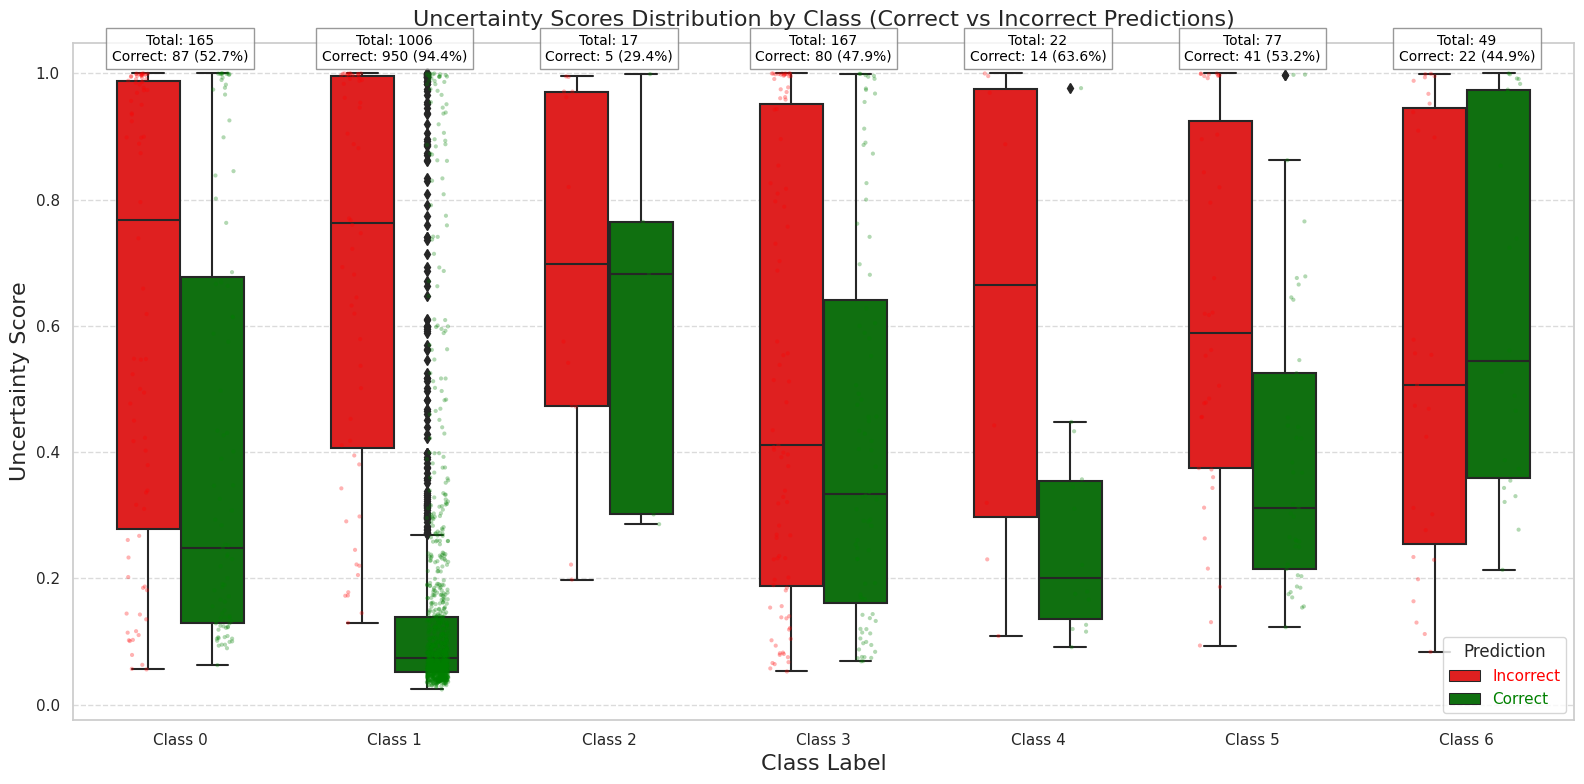

 Lesion Types (Classes in order):  ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'] 

Mean uncertainty by class and correctness:
Correct     False     True 
Class                      
0        0.635856  0.416951
1        0.692781  0.153674
2        0.683175  0.606833
3        0.523367  0.432679
4        0.619280  0.290448
5        0.622061  0.396444
6        0.564728  0.630583

Separation between incorrect and correct prediction uncertainties:
Class
0    0.218905
1    0.539107
2    0.076342
3    0.090688
4    0.328833
5    0.225617
6   -0.065854
Name: Separation, dtype: float32


In [55]:
# model is 'resnet50' Without class balancing
Uncertainty_scores_distribution_classwise('resnet50', resnet50_uncertainty_scores, resnet50_preds, resnet50_labels, save_fig=True)

In [63]:
class_mapping

{'bkl': 0, 'nv': 1, 'df': 2, 'mel': 3, 'vasc': 4, 'bcc': 5, 'akiec': 6}

### 11.2 Uncertainy Scores Distribution of ResNet50 ("With mixup applied")

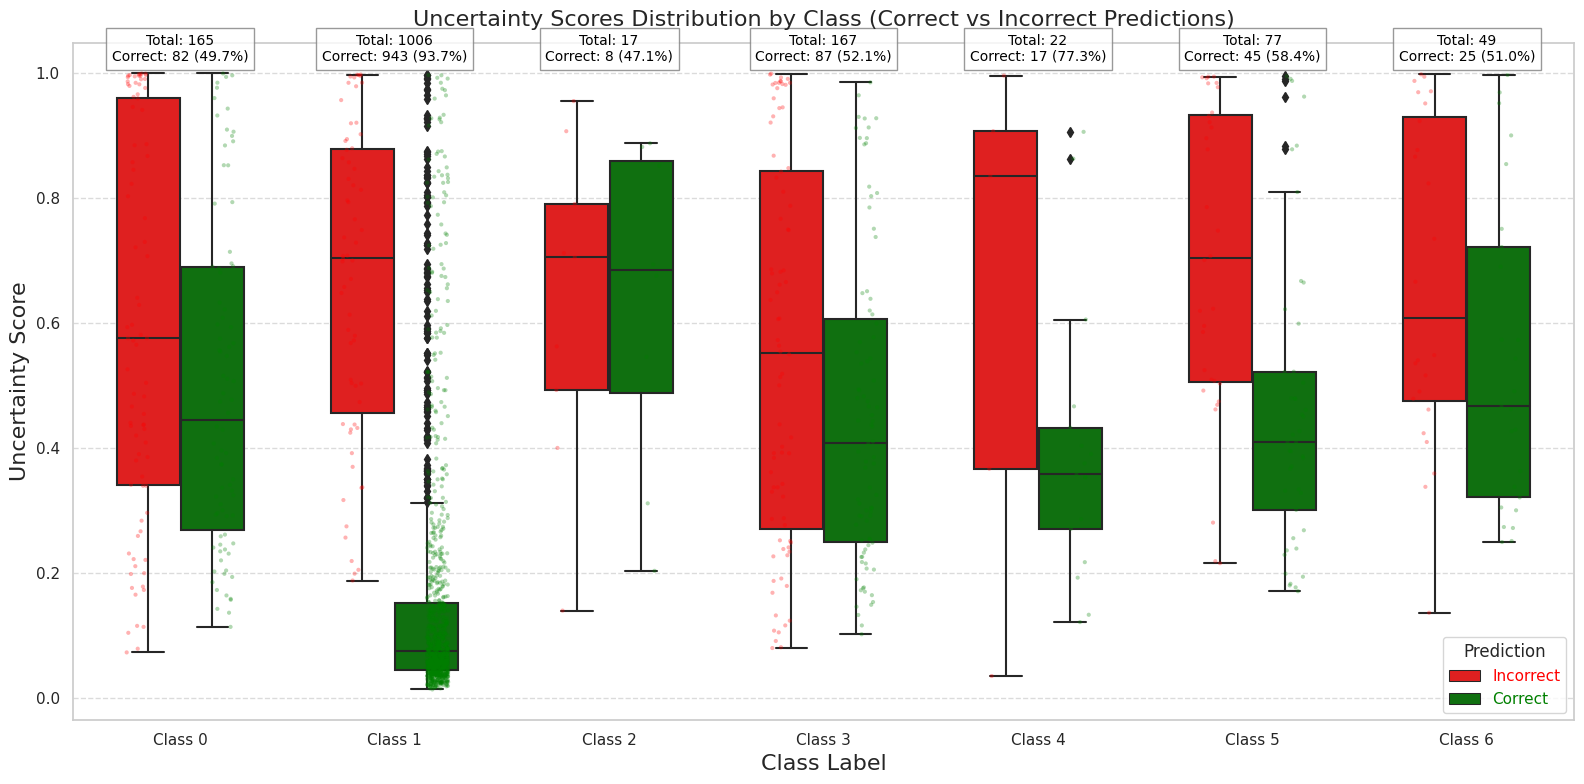

 Lesion Types (Classes in order):  ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'] 

Mean uncertainty by class and correctness:
Correct     False     True 
Class                      
0        0.601195  0.497488
1        0.666032  0.156054
2        0.630010  0.631908
3        0.554183  0.454615
4        0.628517  0.396295
5        0.701042  0.467203
6        0.667189  0.539467

Separation between incorrect and correct prediction uncertainties:
Class
0    0.103708
1    0.509978
2   -0.001898
3    0.099567
4    0.232223
5    0.233838
6    0.127722
Name: Separation, dtype: float32


In [58]:
# model is 'resnet50' with mixup # ---> doesn't oversample minorities, "mixup helps model generalize well during training, which would
#                                     have otherwise led to poor efficiency due to class imbalance issue."

Uncertainty_scores_distribution_classwise('resnet50', resnet50_mixup_uncertainty_scores, resnet50_mixup_preds,
                                          resnet50_mixup_labels, is_mixup=True save_fig=True)

* **Mixup doesn't oversample, so total samples in each class remain the same.**
* **Didn't significantly impacted the majority classes (of the train set) making correct predictions on test set (except for class 3 now making 4% higher correct predictions in test set when mixup is applied).**
*  **But, as expected, all minority classes (class 2,4,5,6) are now showing significantly higher correct predictions % as compared to non-mixup resnet50 case. For ex., class 2 - from 29.4% to 47.1% correct predictions!**
*  **This indeed provides an insight that mixup is helping model generalize well.**
*  **But Uncertainty estimates distribution even after mixup isn't that much satisfactry, as clear from the distributions before and after mixup.**

## 12 Out Of Distribution data and Model Robustness

In [41]:
import torchvision
from torchvision import transforms

In [42]:
def load_cifar10_ood(test_loader_size, ratio=0.5):
    """
    Load CIFAR10 dataset as OOD samples
    Args:
        test_loader_size: Size of skin lesion test dataset
        ratio: Ratio of CIFAR10 samples compared to test dataset size 
    """
    target_size = int(test_loader_size * ratio)
    
    cifar_transform = transforms.Compose([
        transforms.Resize((resized, resized)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])
    
    cifar_dataset = torchvision.datasets.CIFAR10(
        root='/kaggle/working/data', 
        train=False,
        download=not os.path.exists('/kaggle/working/data/cifar-10-python.tar.gz'),   # Download if it doesn't exist at root
        transform=cifar_transform
    )
    
    # Subsample CIFAR10
    indices = torch.randperm(len(cifar_dataset))[:target_size]
    cifar_subset = torch.utils.data.Subset(cifar_dataset, indices)
    
    cifar_loader = DataLoader(
        cifar_subset,
        batch_size=32,
        shuffle=False
    )
    
    return cifar_loader

In [43]:
def evaluate_ood_detection(model, in_dist_loader, ood_loader, device):
    """
    Evaluate model's OOD detection capability
    Returns: uncertainty scores for both in-distribution and OOD samples
    """
    model.eval()
    in_dist_uncertainties = []
    in_dist_confidences = []
    in_dist_predictions = []
    in_dist_labels = []
    
    ood_uncertainties = []
    ood_confidences = []
    
    # Process in-distribution samples (skin lesions)
    with torch.no_grad():
        for inputs, labels in in_dist_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Get model predictions
            evidences = model(inputs)
            alpha = evidences + 1
            S = torch.sum(alpha, dim=1, keepdim=True)
            
            # Calculate uncertainty
            uncertainty = num_classes / S
            confidence = torch.max(alpha / S, dim=1)[0]
            predictions = torch.argmax(alpha / S, dim=1)
            
            in_dist_uncertainties.extend(uncertainty.cpu().numpy())
            in_dist_confidences.extend(confidence.cpu().numpy())
            in_dist_predictions.extend(predictions.cpu().numpy())
            in_dist_labels.extend(labels.cpu().numpy())
    
    # Process OOD samples (CIFAR10)
    with torch.no_grad():
        for inputs, _ in ood_loader:
            inputs = inputs.to(device)
            
            # Get model predictions
            evidences = model(inputs)
            alpha = evidences + 1
            S = torch.sum(alpha, dim=1, keepdim=True)
            
            # Calculate uncertainty
            uncertainty = num_classes / S
            confidence = torch.max(alpha / S, dim=1)[0]
            
            ood_uncertainties.extend(uncertainty.cpu().numpy())
            ood_confidences.extend(confidence.cpu().numpy())
    
    return {
        'in_dist': {
            'uncertainties': np.array(in_dist_uncertainties),
            'confidences': np.array(in_dist_confidences),
            'predictions': np.array(in_dist_predictions),
            'labels': np.array(in_dist_labels)
        },
        'ood': {
            'uncertainties': np.array(ood_uncertainties),
            'confidences': np.array(ood_confidences)
        }
    }

In [44]:
def analyze_ood_performance(results, threshold=0.6):
    """Analyze OOD detection performance metrics"""
    # Calculate metrics
    in_dist_uncertain = results['in_dist']['uncertainties'] >= threshold
    ood_uncertain = results['ood']['uncertainties'] >= threshold
    
    # True Negative Rate (correctly identified in-distribution)
    tnr = np.mean(~in_dist_uncertain)
    # True Positive Rate (correctly identified OOD)
    tpr = np.mean(ood_uncertain)
    
    # Calculate AUROC
    y_true = np.concatenate([np.zeros(len(results['in_dist']['uncertainties'])),
                            np.ones(len(results['ood']['uncertainties']))])
    y_scores = np.concatenate([results['in_dist']['uncertainties'],
                             results['ood']['uncertainties']])
    auroc = roc_auc_score(y_true, y_scores)
    
    return {
        'TNR': tnr,
        'TPR': tpr,
        'AUROC': auroc
    }

* **True Negative Rate** measures how well the model identifies in-distribution samples as in-distribution. The ~ operator inverts the boolean mask because we want samples below the uncertainty threshold (not uncertain = in-distribution).

* **True Positive Rate** measures how well the model identifies OOD samples as OOD. Here we directly use "ood_uncertain" because we want samples above the uncertainty threshold (uncertain = OOD).

In [45]:
def plot_uncertainty_distributions(results_resnet, results_vgg, is_mixup=False):
    """Plot uncertainty distributions comparing ResNet50 and VGG16"""
    print(f"\033[1mUncertainty distribution comparison in presence of OOD samples:\033[0m\n")

    plt.figure(figsize=(15, 5))
    rand_idx = random.randint(0, 50)
    
    # ResNet50 uncertainty distributions
    plt.subplot(1, 2, 1)
    plt.hist(results_resnet['in_dist']['uncertainties'], bins=50, alpha=0.5, 
             label='In-distribution (Skin Lesions)', density=True)
    plt.hist(results_resnet['ood']['uncertainties'], bins=50, alpha=0.5, 
             label='OOD (CIFAR10)', density=True)
    plt.xlabel('Uncertainty')
    plt.ylabel('Density')
    plt.title('ResNet50 Uncertainty Distribution')
    plt.legend()
    
    # VGG16 uncertainty distributions
    plt.subplot(1, 2, 2)
    plt.hist(results_vgg['in_dist']['uncertainties'], bins=50, alpha=0.5, 
             label='In-distribution (Skin Lesions)', density=True)
    plt.hist(results_vgg['ood']['uncertainties'], bins=50, alpha=0.5, 
             label='OOD (CIFAR10)', density=True)
    plt.xlabel('Uncertainty')
    plt.ylabel('Density')
    plt.title('VGG16 Uncertainty Distribution')
    plt.legend()
    
    plt.tight_layout()
    if is_mixup:
        plt.savefig(f'ood_uncertainty_comparison_mixup_{rand_idx}.png')
    else:
        plt.savefig(f'ood_uncertainty_comparison_{rand_idx}.png')
        
    plt.show()

In [102]:
def main_ood_evaluation(model_resnet, model_vgg, ood_ratio=0.5, is_mixup=False):
    test_size = len(test_loader.dataset)
    cifar_loader = load_cifar10_ood(test_size, ratio=ood_ratio)
    print(f"\nLoaded CIFAR10 OOD samples: {len(cifar_loader.dataset)} (ratio: {ood_ratio:.2f})")
    print(f"Test set size: {test_size}")
    
    # Get results for both models
    results_resnet = evaluate_ood_detection(model_resnet, test_loader, cifar_loader, device)
    results_vgg = evaluate_ood_detection(model_vgg, test_loader, cifar_loader, device)
    
    # Print metrics for both models
    for model_name, results in [('ResNet50', results_resnet), ('VGG16', results_vgg)]:
        metrics = analyze_ood_performance(results)
        print(f"\n\033[1mOOD Detection Metrics for {model_name}:")
        print(f"True Negative Rate (correct in-dist): {metrics['TNR']:.3f}")
        print(f"True Positive Rate (correct OOD): {metrics['TPR']:.3f}")
        print(f"AUROC: {metrics['AUROC']:.3f}\033[0m")

        # Additional analysis: Uncertainty vs Accuracy
        correct = results['in_dist']['predictions'] == results['in_dist']['labels']
        print("\n\033[1mUncertainty Analysis:\033[0m")
        print(f"\033[1mMean uncertainty for correct predictions (in-distribution): {results['in_dist']['uncertainties'][correct].mean():.3f}")
        print(f"Mean uncertainty for incorrect predictions(in-distribution): {results['in_dist']['uncertainties'][~correct].mean():.3f}\033[0m")

    
    # Plot distributions comparing both models
    plot_uncertainty_distributions(results_resnet, results_vgg, is_mixup)

After model training section but before the final evaluation. Here's how to interpret the results:

**1. Uncertainty Distribution:**

    1.1 In-distribution samples should have lower uncertainty
    1.2 CIFAR10 (OOD) samples should have higher uncertainty
    1.3 Clear separation between distributions indicates good OOD detection

**2. Metrics to look for:**

    2.1 High TNR: Model correctly identifies in-distribution samples
    2.2 High TPR: Model correctly identifies OOD samples
    2.3 High AUROC: Good overall discrimination between in-distribution and OOD
    2.4 Higher uncertainty for incorrect predictions vs correct ones

#### Models Without Mixup

In [32]:
# # LOAD Resnet50 (Without mixup and mse loss) model 
# checkpoint = torch.load("/kaggle/input/resnet50_mse/pytorch/default/1/resnet50_uncertainty_mse.pt", map_location = torch.device(device))
# edl_resnet50_model.load_state_dict(checkpoint["model_state_dict"])  # Load the final saved model
# optimizer_resnet50.load_state_dict(checkpoint["optimizer_state_dict"])

In [33]:
# # LOAD VGG16 (Without mixup and digamma loss) model 
# checkpoint_vgg16 = torch.load("/kaggle/input/vgg16_digamma/pytorch/default/1/VGG16_uncertainty_digamma.pt", map_location = torch.device(device))
# edl_VGG16_model.load_state_dict(checkpoint_vgg16["model_state_dict"])  # Load the final saved model
# optimizer_VGG16.load_state_dict(checkpoint_vgg16["optimizer_state_dict"])


Loaded CIFAR10 OOD samples: 751 (ratio: 0.5)
Test set size: 1503

OOD Detection Metrics for ResNet50:
True Negative Rate (correct in-dist): 0.794
True Positive Rate (correct OOD): 0.308
AUROC: 0.610

Uncertainty Analysis:
Mean uncertainty for correct predictions (in-distribution): 0.217
Mean uncertainty for incorrect predictions(in-distribution): 0.607

OOD Detection Metrics for VGG16:
True Negative Rate (correct in-dist): 0.516
True Positive Rate (correct OOD): 0.246
AUROC: 0.403

Uncertainty Analysis:
Mean uncertainty for correct predictions (in-distribution): 0.513
Mean uncertainty for incorrect predictions(in-distribution): 0.843
Uncertainty distribution comparison in presence of OOD samples:



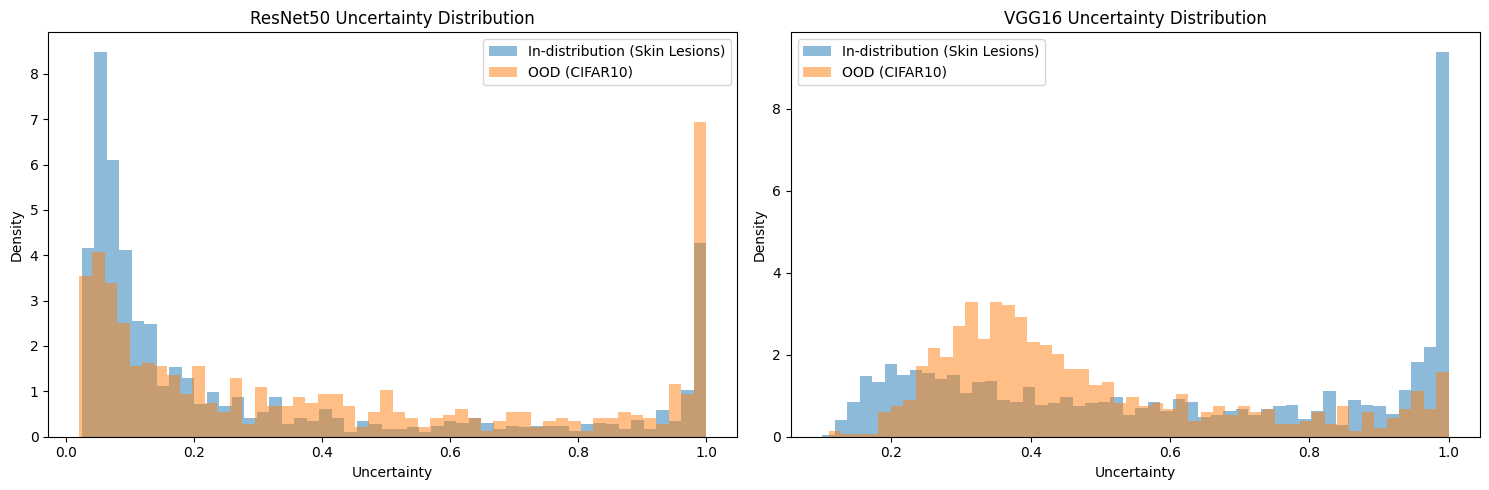

In [36]:
# Execute evaluation with desired ratio
main_ood_evaluation(edl_resnet50_model, edl_VGG16_model, ood_ratio=0.5)  

What if in-distribution samples and OOD samples are equal in size?


Loaded CIFAR10 OOD samples: 1503 (ratio: 1.0)
Test set size: 1503

OOD Detection Metrics for ResNet50:
True Negative Rate (correct in-dist): 0.800
True Positive Rate (correct OOD): 0.363
AUROC: 0.625

Uncertainty Analysis:
Mean uncertainty for correct predictions (in-distribution): 0.228
Mean uncertainty for incorrect predictions(in-distribution): 0.616

OOD Detection Metrics for VGG16:
True Negative Rate (correct in-dist): 0.522
True Positive Rate (correct OOD): 0.241
AUROC: 0.405

Uncertainty Analysis:
Mean uncertainty for correct predictions (in-distribution): 0.511
Mean uncertainty for incorrect predictions(in-distribution): 0.850
Uncertainty distribution comparison in presence of OOD samples:



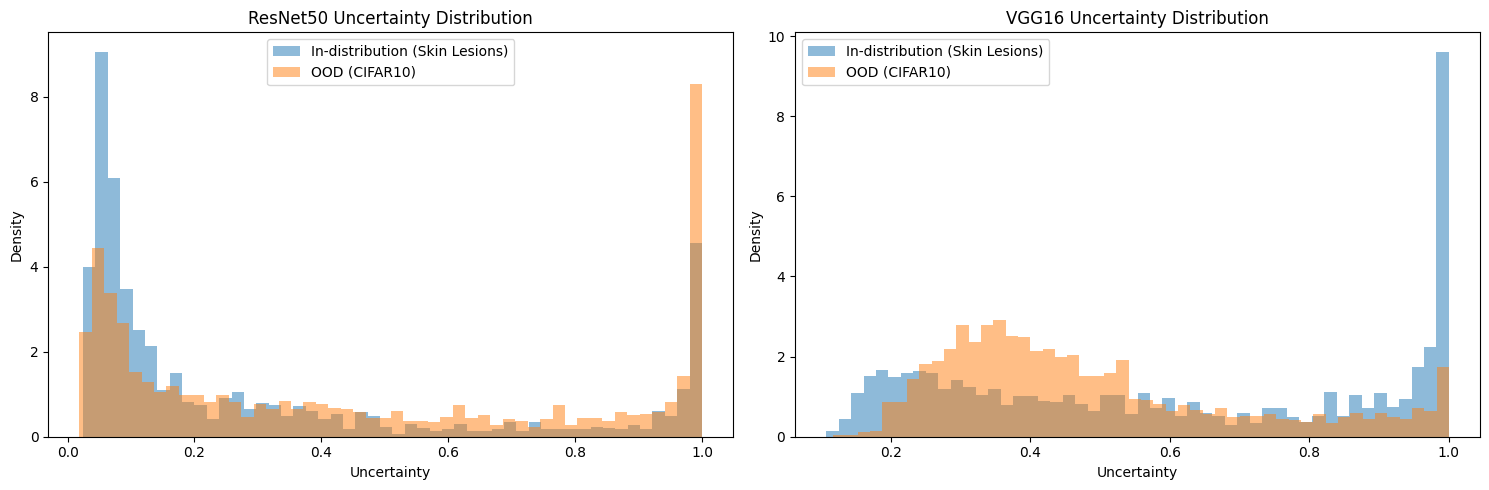

In [37]:
# Execute evaluation with desired ratio
print("\033[1mWhat if in-distribution samples and OOD samples are equal in size?\033[0m\n")
models_eval_results_R1 = main_ood_evaluation(edl_resnet50_model, edl_VGG16_model, ood_ratio=1.0)  


Loaded CIFAR10 OOD samples: 375 (ratio: 0.25)
Test set size: 1503

OOD Detection Metrics for ResNet50:
True Negative Rate (correct in-dist): 0.796
True Positive Rate (correct OOD): 0.328
AUROC: 0.626

Uncertainty Analysis:
Mean uncertainty for correct predictions (in-distribution): 0.218
Mean uncertainty for incorrect predictions(in-distribution): 0.632

OOD Detection Metrics for VGG16:
True Negative Rate (correct in-dist): 0.519
True Positive Rate (correct OOD): 0.221
AUROC: 0.398

Uncertainty Analysis:
Mean uncertainty for correct predictions (in-distribution): 0.509
Mean uncertainty for incorrect predictions(in-distribution): 0.849
Uncertainty distribution comparison in presence of OOD samples:



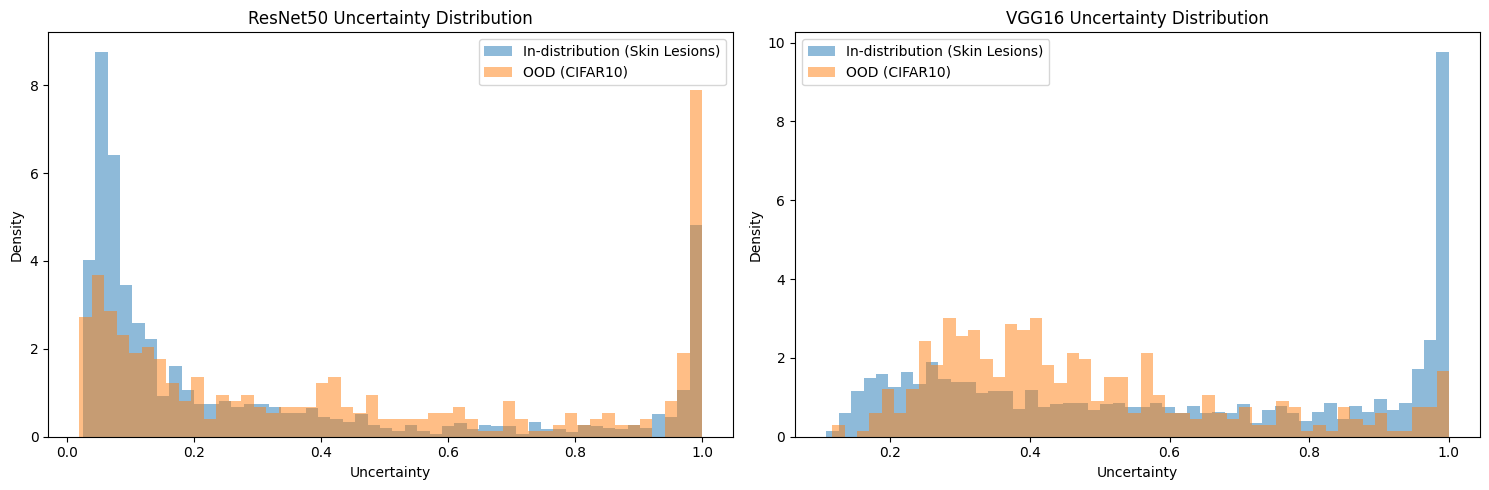

In [40]:
# Execute evaluation with desired ratio
models_eval_results_R25 = main_ood_evaluation(edl_resnet50_model, edl_VGG16_model, ood_ratio=0.25)  

#### Models With Mixup

In [41]:
# # Load Resnet50 (WITH Mixup and mse loss)
# checkpoint_mixup = torch.load("/kaggle/input/resnet50_mse_mixup/pytorch/default/1/resnet50_uncertainty_mse_MIXUP.pt", map_location = torch.device(device))
# edl_resnet50_model.load_state_dict(checkpoint_mixup["model_state_dict"])  # Load the final saved model
# optimizer_resnet50.load_state_dict(checkpoint_mixup["optimizer_state_dict"])

In [42]:
# # Load VGG16 (WITH Mixup and Digamma loss)
# checkpoint_VGG16_mixup = torch.load("/kaggle/input/vgg16_digamma_mixup/pytorch/default/1/VGG16_uncertainty_digamma_MIXUP.pt", map_location = torch.device(device))
# edl_VGG16_model.load_state_dict(checkpoint_VGG16_mixup["model_state_dict"])  # Load the final saved model
# optimizer_VGG16.load_state_dict(checkpoint_VGG16_mixup["optimizer_state_dict"])


Loaded CIFAR10 OOD samples: 1503 (ratio: 1.00)
Test set size: 1503

OOD Detection Metrics for ResNet50:
True Negative Rate (correct in-dist): 0.806
True Positive Rate (correct OOD): 0.200
AUROC: 0.497

Uncertainty Analysis:
Mean uncertainty for correct predictions (in-distribution): 0.231
Mean uncertainty for incorrect predictions(in-distribution): 0.610

OOD Detection Metrics for VGG16:
True Negative Rate (correct in-dist): 0.674
True Positive Rate (correct OOD): 0.077
AUROC: 0.352

Uncertainty Analysis:
Mean uncertainty for correct predictions (in-distribution): 0.405
Mean uncertainty for incorrect predictions(in-distribution): 0.746
Uncertainty distribution comparison in presence of OOD samples:



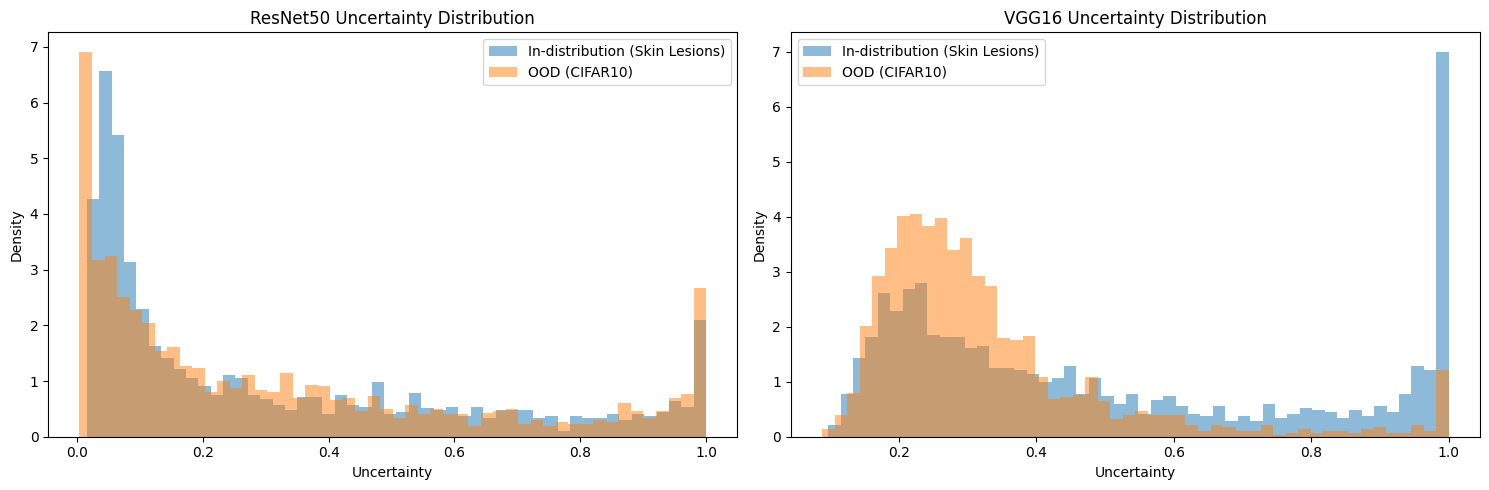

In [43]:
# Execute evaluation with desired ratio
main_ood_evaluation(edl_resnet50_model, edl_VGG16_model, ood_ratio=1.0, is_mixup=True)  


Loaded CIFAR10 OOD samples: 751 (ratio: 0.50)
Test set size: 1503

OOD Detection Metrics for ResNet50:
True Negative Rate (correct in-dist): 0.796
True Positive Rate (correct OOD): 0.200
AUROC: 0.508

Uncertainty Analysis:
Mean uncertainty for correct predictions (in-distribution): 0.236
Mean uncertainty for incorrect predictions(in-distribution): 0.615

OOD Detection Metrics for VGG16:
True Negative Rate (correct in-dist): 0.669
True Positive Rate (correct OOD): 0.085
AUROC: 0.356

Uncertainty Analysis:
Mean uncertainty for correct predictions (in-distribution): 0.407
Mean uncertainty for incorrect predictions(in-distribution): 0.748
Uncertainty distribution comparison in presence of OOD samples:



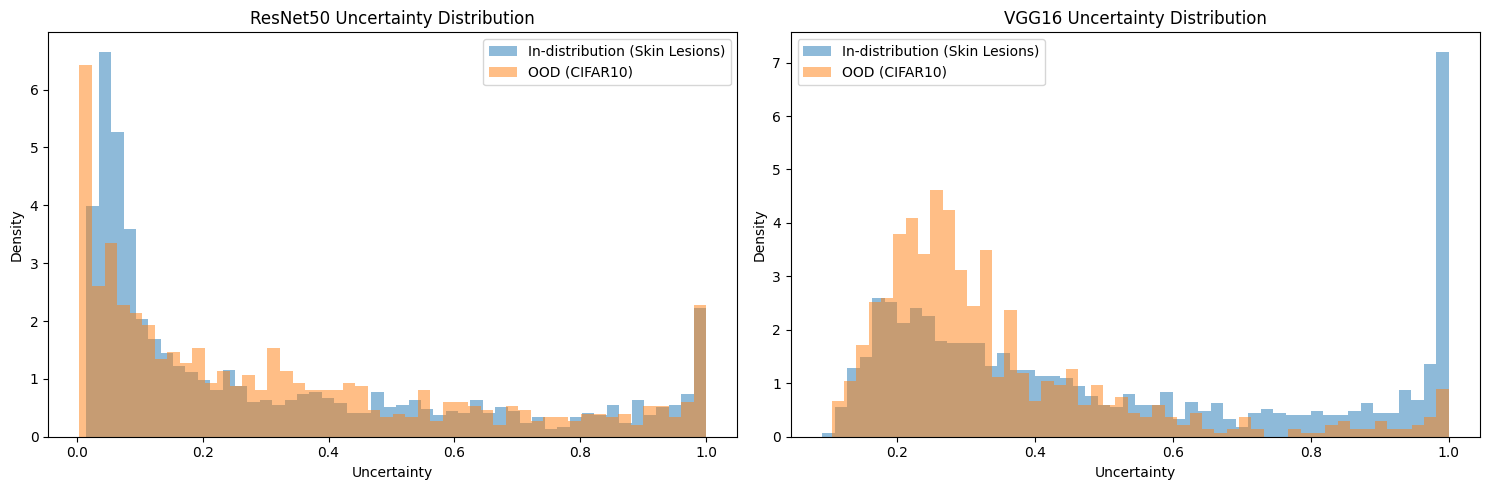

In [44]:
# Execute evaluation with desired ratio
main_ood_evaluation(edl_resnet50_model, edl_VGG16_model, ood_ratio=0.5, is_mixup=True)  


Loaded CIFAR10 OOD samples: 375 (ratio: 0.25)
Test set size: 1503

OOD Detection Metrics for ResNet50:
True Negative Rate (correct in-dist): 0.803
True Positive Rate (correct OOD): 0.179
AUROC: 0.507

Uncertainty Analysis:
Mean uncertainty for correct predictions (in-distribution): 0.232
Mean uncertainty for incorrect predictions(in-distribution): 0.620

OOD Detection Metrics for VGG16:
True Negative Rate (correct in-dist): 0.669
True Positive Rate (correct OOD): 0.083
AUROC: 0.334

Uncertainty Analysis:
Mean uncertainty for correct predictions (in-distribution): 0.402
Mean uncertainty for incorrect predictions(in-distribution): 0.751
Uncertainty distribution comparison in presence of OOD samples:



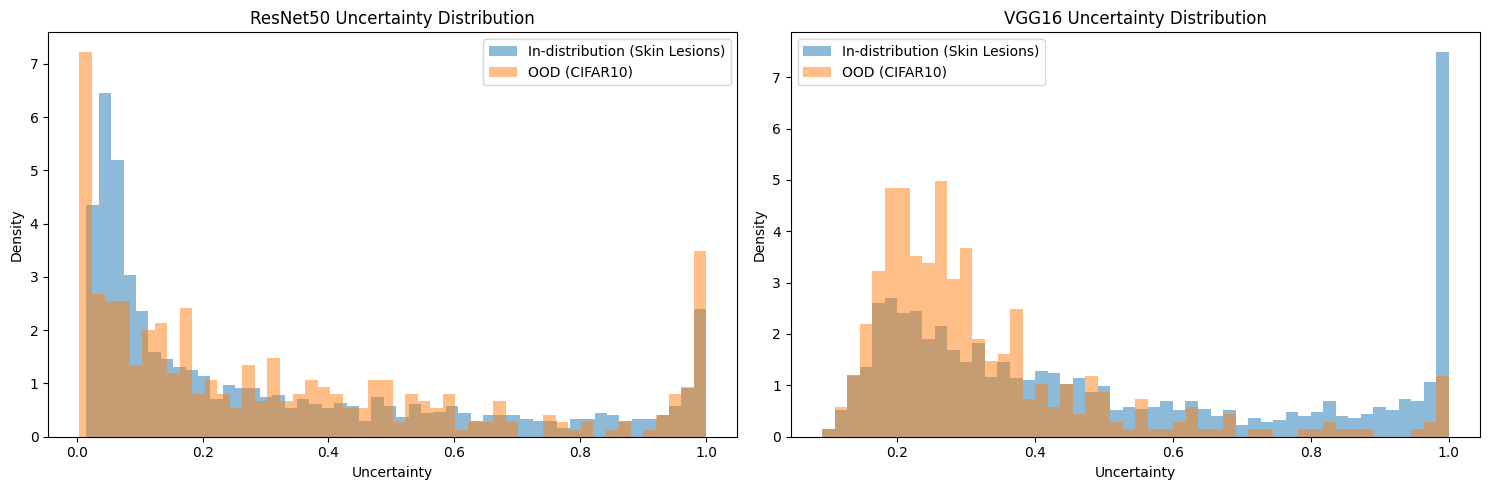

In [46]:
# Execute evaluation with desired ratio
main_ood_evaluation(edl_resnet50_model, edl_VGG16_model, ood_ratio=0.25, is_mixup=True)  

## 13. Focal Loss' Integration

* **We need a weighted sum of all the three losses - edl loss, kl divergence loss, and focal loss.**
* **Below class is an improved version of the original focal loss, and achieves the integration of these loss upon calling.** 

In [29]:
class Improved_EDL_FocalLoss(nn.Module):
    """Improve upon Vanilla EDL's losses to include Focall loss to focus on Minority classes"""
    
    def __init__(self, annealing_step=10, num_classes=7, gamma=2.0, alpha=None, 
                 focal_weight=0.5, edl_weight=0.5, name="improved_focal_edl"):
        super(Improved_EDL_FocalLoss, self).__init__()
        self.annealing_step = annealing_step
        self.num_classes = num_classes
        self.gamma = gamma
        self.focal_weight = focal_weight
        self.edl_weight = edl_weight
        self.name = name
        
        # Initialize alpha if not provided
        if alpha is None:
            self.alpha = torch.ones(num_classes).to(device)
        else:
            self.alpha = alpha.to(device)

    def forward(self, evidences, label, labels_list, epoch_num, is_mixup=False, mixup_lam=None):
        alpha = evidences + 1
        S = torch.sum(alpha, dim=1, keepdim=True)
        
        # Calculate probabilities from evidences
        probs = alpha / S
        
        if is_mixup:
            label_one_hot = label
        else:
            label_one_hot = F.one_hot(label, num_classes=self.num_classes).float()
        
        # Focal loss component
        p_t = torch.sum(label_one_hot * probs, dim=1)
        focal_term = (1 - p_t) ** self.gamma
        
        # Apply class weights to focal term
        if not is_mixup:
            at = self.alpha.gather(0, label.data)
            focal_loss = torch.mean(at * focal_term * (-torch.log(p_t + 1e-10)))
        else:
            # For mixup, use the 'lam' value for weighting class weights
            if mixup_lam is not None:
                y_i_class = torch.argmax(labels_list[0], dim=1)
                y_j_class = torch.argmax(labels_list[1], dim=1)
                at_i = self.alpha.gather(0, y_i_class)
                at_j = self.alpha.gather(0, y_j_class)
                at_mix = mixup_lam * at_i + (1 - mixup_lam) * at_j
                focal_loss = torch.mean(at_mix * focal_term * (-torch.log(p_t + 1e-10)))
            else:
                # Fallback if lam not provided
                focal_loss = torch.mean(focal_term * (-torch.log(p_t + 1e-10)))
        
        # EDL uncertainty loss (standard digamma loss)
        digamma_sum = torch.digamma(S)
        digamma_alpha = torch.digamma(alpha)
        edl_loss = torch.mean(torch.sum(label_one_hot * (digamma_sum - digamma_alpha), dim=1))
        
        # KL divergence term with annealing
        annealing_coef = torch.min(
            torch.tensor(1.0, dtype=torch.float32),
            torch.tensor(epoch_num / self.annealing_step, dtype=torch.float32)
        )
        kl_loss = KL_divergence(evidences, labels_list, is_mixup)
        
        # Combine losses with weights
        total_loss = (self.focal_weight * focal_loss + 
                      self.edl_weight * edl_loss + 
                      annealing_coef * kl_loss)
        
        return total_loss
        
    def update_alpha(self, class_counts):
        """Dynamically adjust class weights based on class distribution"""
        total_samples = sum(class_counts)
        # Inverse frequency weighting
        self.alpha = torch.tensor(
            [total_samples / (self.num_classes * count) for count in class_counts]
        ).to(device)

In [30]:
# Function to calculate class distribution
def get_class_distribution(dataloader):
    class_counts = torch.zeros(num_classes)
    for _, labels in dataloader:
        for label in labels:
            class_counts[label] += 1
    return class_counts

In [31]:
def mixup_criterion_focal(criterion, evidences, y_i, y_j, lam, epoch_num):
    labels_list = [y_i, y_j]
    return lam * criterion.forward(evidences, y_i, labels_list, epoch_num, is_mixup=True, mixup_lam=lam) \
            + (1 - lam) * criterion.forward(evidences, y_j, labels_list, epoch_num, is_mixup=True, mixup_lam=1-lam)

In [49]:
def train_with_focal_edl(train_resnet:bool, train_vgg:bool):
    edl_resnet50_model_focal = EDL_model_based(resnet50, 7, num_classes=num_classes, pretrained=True, evidence_scale=1.0)
    edl_vgg16_model_focal = EDL_model_based(vgg16, 5, num_classes=num_classes, pretrained=True, evidence_scale=1.0)
    
    # class distribution
    class_counts = get_class_distribution(train_loader)
    # print("Class distribution:", class_counts)
    
    # Create the improved loss function with initial balanced weights
    criterion = Improved_EDL_FocalLoss(
        annealing_step=annealing_step,
        num_classes=num_classes,
        gamma=2.0,
        focal_weight=0.5,  # Starting with balanced weights
        edl_weight=0.5
    )
    criterion.update_alpha(class_counts)
    
    # Optimizers
    opt_resnet = torch.optim.Adam(
        filter(lambda p: p.requires_grad, edl_resnet50_model_focal.parameters()),
        lr=0.001
    )
    opt_vgg = torch.optim.Adam(
        filter(lambda p: p.requires_grad, edl_vgg16_model_focal.parameters()),
        lr=0.001
    )
    
    # Train ResNet50
    if train_resnet and not train_vgg:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_resnet, mode='min', factor=0.5, 
                                                               patience=3, verbose=True)

        edl_resnet50_model_focal = edl_resnet50_model_focal.to(device)
        edl_resnet50_model_focal, metrics_resnet50_focal = train_model_mixup(
            edl_resnet50_model_focal,
            dataloaders,
            num_classes,
            criterion,
            opt_resnet,
            mixup_alpha,
            num_epochs,
            device,
            scheduler=scheduler,
            uncertainty=True,
            logits=False,
            is_focal=True,
            is_resnet50=True
        )
        
        return edl_resnet50_model_focal.to(device), metrics_resnet50_focal
        
    # Train VGG16
    elif train_vgg and not train_resnet:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_vgg, mode='min', factor=0.5, 
                                                               patience=3, verbose=True)
        
        edl_vgg16_model_focal = edl_vgg16_model_focal.to(device)
        edl_vgg16_model_focal, metrics_vgg16_focal = train_model_mixup(
            edl_vgg16_model_focal,
            dataloaders,
            num_classes,
            criterion,
            opt_vgg,
            mixup_alpha,
            num_epochs,
            device,
            scheduler=scheduler,
            uncertainty=True,
            logits=False,
            is_focal=True,
            is_resnet50=False
        )
    
        return edl_vgg16_model_focal.to(device), metrics_vgg16_focal
    
    else: 
        print("Train one model at a time by specifying True for one and False for the other.")

### edl resnet50 with focal loss

In [33]:
num_epochs = 30
# num_epochs = 20  # new value
# num_epochs = 10  # additional runs

In [34]:
# train_resnet should be True and other false
edl_resnet50_model_focal, metrics_resnet50_focal = train_with_focal_edl(train_resnet=True, train_vgg=False)   


Epoch 1/30 :

Adaptive weights: Focal=0.7, EDL=0.3

'' Training using improved_focal_edl loss...
Train loss: 1.1722 acc: 67.6185
----------
Validating...
Val loss: 1.1369 acc: 15.3239
----------

Learning rate: 0.001000


Epoch 2/30 :

Adaptive weights: Focal=0.7, EDL=0.3

'' Training using improved_focal_edl loss...
Train loss: 1.0930 acc: 72.4423
----------
Validating...
Val loss: 1.0399 acc: 15.6090
----------

Learning rate: 0.001000


Epoch 3/30 :

Adaptive weights: Focal=0.7, EDL=0.3

'' Training using improved_focal_edl loss...
Train loss: 1.0587 acc: 67.5615
----------
Validating...
Val loss: 1.1223 acc: 14.6315
----------

Learning rate: 0.001000


Epoch 4/30 :

Adaptive weights: Focal=0.7, EDL=0.3

'' Training using improved_focal_edl loss...
Train loss: 1.0707 acc: 72.0652
----------
Validating...
Val loss: 1.0624 acc: 17.6071
----------

Learning rate: 0.001000


Epoch 5/30 :

Adaptive weights: Focal=0.7, EDL=0.3

'' Training using improved_focal_edl loss...
Train loss: 1.

In [48]:
edl_resnet50_model_focal = edl_resnet50_model_focal.to(device)

#### edl vgg16 with focal loss

In [35]:
# train_resnet should be False and other True
edl_vgg16_model_focal, metrics_vgg16_focal = train_with_focal_edl(train_resnet=False, train_vgg=True)   


Epoch 1/30 :

Adaptive weights: Focal=0.7, EDL=0.3

'' Training using improved_focal_edl loss...
Train loss: 1.2570 acc: 66.8938
----------
Validating...
Val loss: 1.2337 acc: 15.0266
----------

Learning rate: 0.001000


Epoch 2/30 :

Adaptive weights: Focal=0.7, EDL=0.3

'' Training using improved_focal_edl loss...
Train loss: 1.2295 acc: 72.0231
----------
Validating...
Val loss: 1.1823 acc: 14.8830
----------

Learning rate: 0.001000


Epoch 3/30 :

Adaptive weights: Focal=0.7, EDL=0.3

'' Training using improved_focal_edl loss...
Train loss: 1.2697 acc: 72.9150
----------
Validating...
Val loss: 1.2888 acc: 16.3912
----------

Learning rate: 0.001000


Epoch 4/30 :

Adaptive weights: Focal=0.7, EDL=0.3

'' Training using improved_focal_edl loss...
Train loss: 1.2638 acc: 73.1455
----------
Validating...
Val loss: 1.2000 acc: 14.6186
----------

Learning rate: 0.001000


Epoch 5/30 :

Adaptive weights: Focal=0.7, EDL=0.3

'' Training using improved_focal_edl loss...
Train loss: 1.

In [50]:
edl_vgg16_model_focal = edl_vgg16_model_focal.to(device)

### Test Models (Focal loss trained)

### ResNet50

 Lesion Types:  ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'] 

Original image shape:
 torch.Size([1, 3, 64, 64])

  Probs: tensor([0.1810, 0.1475, 0.1570, 0.1336, 0.1296, 0.0925, 0.1588],
       device='cuda:0')

  Prediction:  tensor(0, device='cuda:0')
  Ground truth: tensor(1)

  Uncertainty estimate: tensor([[0.5357]], device='cuda:0')  



<Figure size 700x500 with 0 Axes>

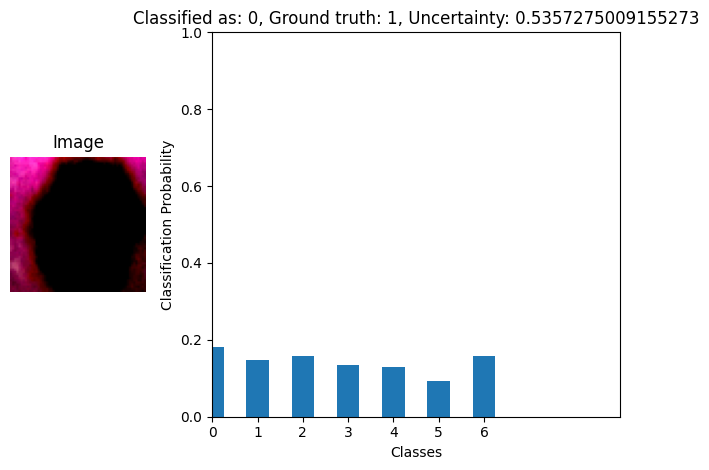

In [93]:
test_single_image(edl_resnet50_model_focal, test_loader, uncertainty=True, is_mixup=True)

### VGG16

 Lesion Types:  ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'] 

Original image shape:
 torch.Size([1, 3, 64, 64])

  Probs: tensor([0.0763, 0.5424, 0.0762, 0.0762, 0.0764, 0.0762, 0.0762],
       device='cuda:0')

  Prediction:  tensor(1, device='cuda:0')
  Ground truth: tensor(1)

  Uncertainty estimate: tensor([[0.5337]], device='cuda:0')  



<Figure size 700x500 with 0 Axes>

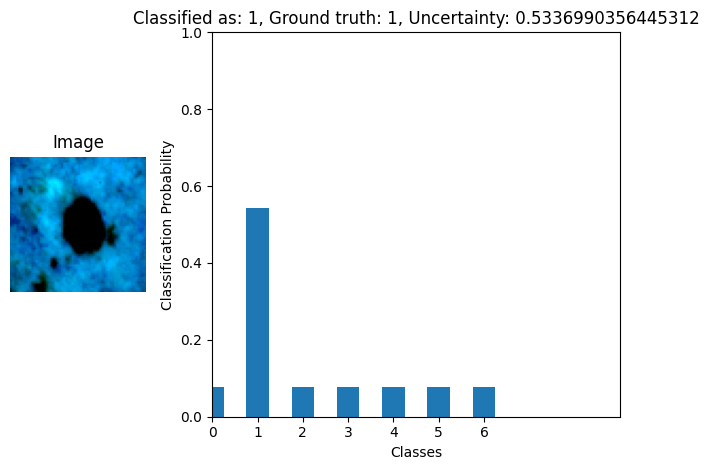

In [85]:
test_single_image(edl_vgg16_model_focal, test_loader, uncertainty=True, is_mixup=True)

## 14. Metrics after using Focal loss

### **AUC Metric**

### ResNet50 + mixup + Focal loss

In [52]:
auc_metric(edl_resnet50_model_focal, test_loader)

 AUC of loaded model: 0.9109 


#### VGG16 + mixup + Focal loss

In [95]:
auc_metric(edl_vgg16_model_focal, test_loader)

 AUC of loaded model: 0.8364 


### **Uncertainty Confusion Metric**

In [87]:
resnet50_focal_uncertainty_scores, resnet50_focal_preds, resnet50_focal_labels = uncertainty_confusion_metric(edl_resnet50_model_focal, test_loader)

Uncertainty scores: tensor([0.6848, 0.4207, 0.2953,  ..., 0.2928, 0.3540, 0.7163]) 
Uncertainty scores shape: torch.Size([1503])
all_preds shape: torch.Size([1503])
all_labels shape: torch.Size([1503])
----------------------------------------------------------------------------------------------------

Uncertainty threshold (mean of uncertainty_scores) is: 0.4511905908584595
i.e., when Model is at least 54.88094091415405% confident:

Uncertainty Confusion Matrix:
[[CC, IC],
[CU, IU]]

tensor([[742,  47],
        [471, 243]])
****************************************************************************************************

Uncertainty threshold (median of uncertainty_scores) is: 0.43515628576278687
i.e., when Model is at least 56.48437142372131% confident:

Uncertainty Confusion Matrix:
[[CC, IC],
[CU, IU]]

tensor([[709,  43],
        [504, 247]])
****************************************************************************************************

Uncertainty threshold is: 0.2
i.e.,

In [98]:
# resnet50_focal_uncertainty_scores, resnet50_focal_preds, resnet50_focal_labels = uncertainty_confusion_metric(edl_resnet50_model_focal, test_loader)

Uncertainty scores: tensor([0.5809, 0.5653, 0.5755,  ..., 0.5697, 0.5823, 0.5876]) 
Uncertainty scores shape: torch.Size([1503])
all_preds shape: torch.Size([1503])
all_labels shape: torch.Size([1503])
----------------------------------------------------------------------------------------------------

Uncertainty threshold (mean of uncertainty_scores) is: 0.5659101605415344
i.e., when Model is at least 43.40898394584656% confident:

Uncertainty Confusion Matrix:
[[CC, IC],
[CU, IU]]

tensor([[   8,  326],
        [  87, 1082]])
****************************************************************************************************

Uncertainty threshold (median of uncertainty_scores) is: 0.5760915875434875
i.e., when Model is at least 42.390841245651245% confident:

Uncertainty Confusion Matrix:
[[CC, IC],
[CU, IU]]

tensor([[ 28, 724],
        [ 67, 684]])
****************************************************************************************************

Uncertainty threshold is: 0.2
i

In [96]:
vgg16_focal_uncertainty_scores, vgg16_focal_preds, vgg16_focal_labels = uncertainty_confusion_metric(edl_vgg16_model_focal, test_loader)

Uncertainty scores: tensor([0.9959, 0.6313, 0.5964,  ..., 0.3549, 0.4398, 0.8347]) 
Uncertainty scores shape: torch.Size([1503])
all_preds shape: torch.Size([1503])
all_labels shape: torch.Size([1503])
----------------------------------------------------------------------------------------------------

Uncertainty threshold (mean of uncertainty_scores) is: 0.5731475949287415
i.e., when Model is at least 42.685240507125854% confident:

Uncertainty Confusion Matrix:
[[CC, IC],
[CU, IU]]

tensor([[750,  90],
        [359, 304]])
****************************************************************************************************

Uncertainty threshold (median of uncertainty_scores) is: 0.5240160226821899
i.e., when Model is at least 47.598397731781006% confident:

Uncertainty Confusion Matrix:
[[CC, IC],
[CU, IU]]

tensor([[692,  60],
        [417, 334]])
****************************************************************************************************

Uncertainty threshold is: 0.2
i.e.

### 

## 15. Uncertainty Score distribution (Focal loss case)

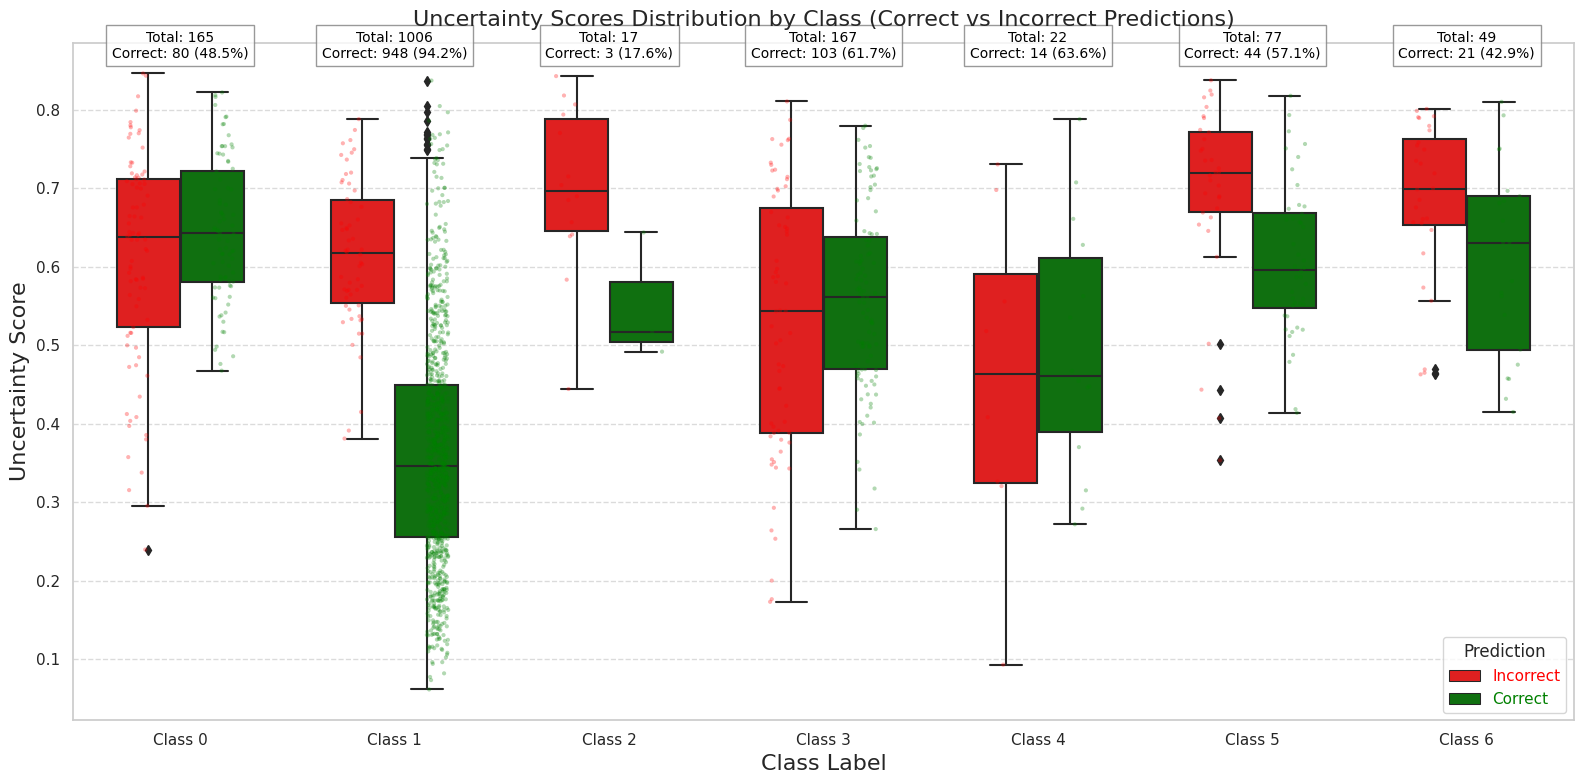

 Lesion Types (Classes in order):  {'bkl': 0, 'nv': 1, 'df': 2, 'mel': 3, 'vasc': 4, 'bcc': 5, 'akiec': 6} 

Mean uncertainty by class and correctness:
Correct     False     True 
Class                      
0        0.611612  0.646596
1        0.615546  0.362531
2        0.699500  0.550979
3        0.528913  0.557947
4        0.456272  0.496254
5        0.695662  0.609173
6        0.684352  0.607561

Separation between incorrect and correct prediction uncertainties:
Class
0   -0.034984
1    0.253015
2    0.148522
3   -0.029034
4   -0.039982
5    0.086489
6    0.076791
Name: Separation, dtype: float32


In [101]:
Uncertainty_scores_distribution_classwise('resnet50_focal', resnet50_focal_uncertainty_scores, resnet50_focal_preds, 
                                          resnet50_focal_labels, is_mixup=True, save_fig=True)

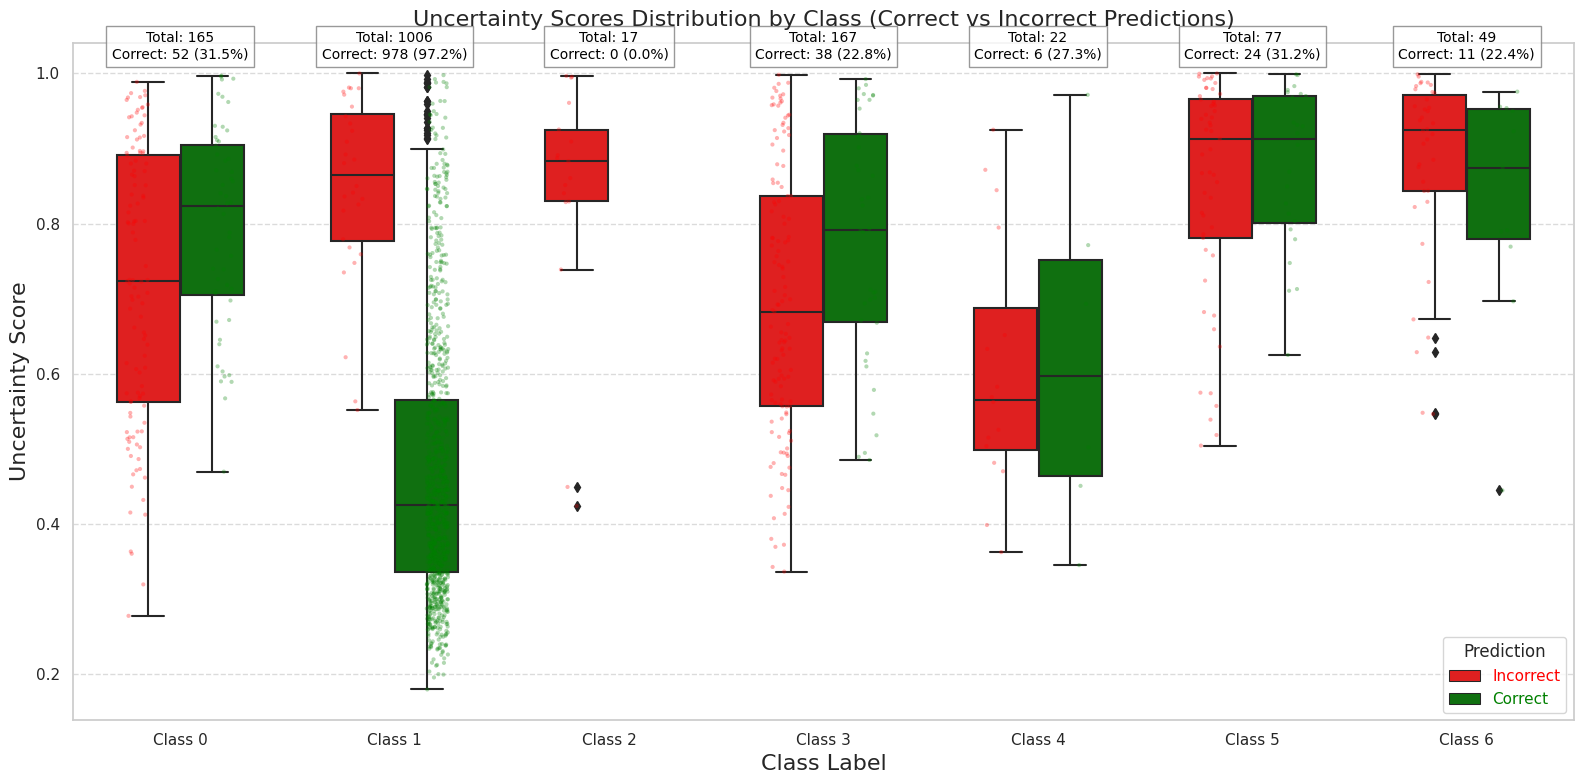

 Lesion Types (Classes in order):  {'bkl': 0, 'nv': 1, 'df': 2, 'mel': 3, 'vasc': 4, 'bcc': 5, 'akiec': 6} 

Mean uncertainty by class and correctness:
Correct     False     True 
Class                      
0        0.717137  0.794879
1        0.847926  0.470232
2        0.839235       NaN
3        0.694582  0.776284
4        0.605794  0.622390
5        0.851404  0.874762
6        0.879089  0.829473

Separation between incorrect and correct prediction uncertainties:
Class
0   -0.077743
1    0.377694
2         NaN
3   -0.081702
4   -0.016596
5   -0.023358
6    0.049616
Name: Separation, dtype: float32


In [100]:
Uncertainty_scores_distribution_classwise('vgg16_focal', vgg16_focal_uncertainty_scores, vgg16_focal_preds, 
                                          vgg16_focal_labels, is_mixup=True, save_fig=True)

## 16. OOD Robustness after Focal loss integration

100%|██████████| 170498071/170498071 [00:03<00:00, 49468869.53it/s]


Extracting /kaggle/working/data/cifar-10-python.tar.gz to /kaggle/working/data

Loaded CIFAR10 OOD samples: 751 (ratio: 0.50)
Test set size: 1503

OOD Detection Metrics for ResNet50:
True Negative Rate (correct in-dist): 1.000
True Positive Rate (correct OOD): 0.000
AUROC: 0.535

Uncertainty Analysis:
Mean uncertainty for correct predictions (in-distribution): 0.579
Mean uncertainty for incorrect predictions(in-distribution): 0.565

OOD Detection Metrics for VGG16:
True Negative Rate (correct in-dist): 0.590
True Positive Rate (correct OOD): 0.177
AUROC: 0.402

Uncertainty Analysis:
Mean uncertainty for correct predictions (in-distribution): 0.506
Mean uncertainty for incorrect predictions(in-distribution): 0.753
Uncertainty distribution comparison in presence of OOD samples:



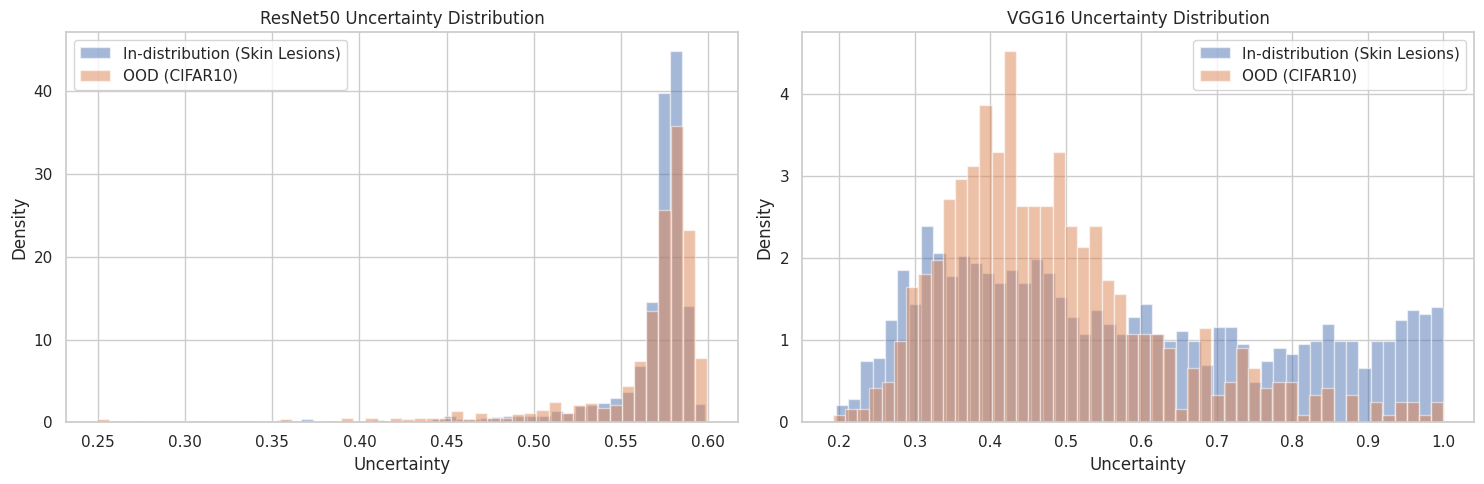

In [103]:
# Execute evaluation with desired ratio
main_ood_evaluation(edl_resnet50_model_focal, edl_vgg16_model_focal, ood_ratio=0.5)  


Loaded CIFAR10 OOD samples: 375 (ratio: 0.25)
Test set size: 1503

OOD Detection Metrics for ResNet50:
True Negative Rate (correct in-dist): 1.000
True Positive Rate (correct OOD): 0.000
AUROC: 0.546

Uncertainty Analysis:
Mean uncertainty for correct predictions (in-distribution): 0.578
Mean uncertainty for incorrect predictions(in-distribution): 0.565

OOD Detection Metrics for VGG16:
True Negative Rate (correct in-dist): 0.583
True Positive Rate (correct OOD): 0.195
AUROC: 0.412

Uncertainty Analysis:
Mean uncertainty for correct predictions (in-distribution): 0.509
Mean uncertainty for incorrect predictions(in-distribution): 0.756
Uncertainty distribution comparison in presence of OOD samples:



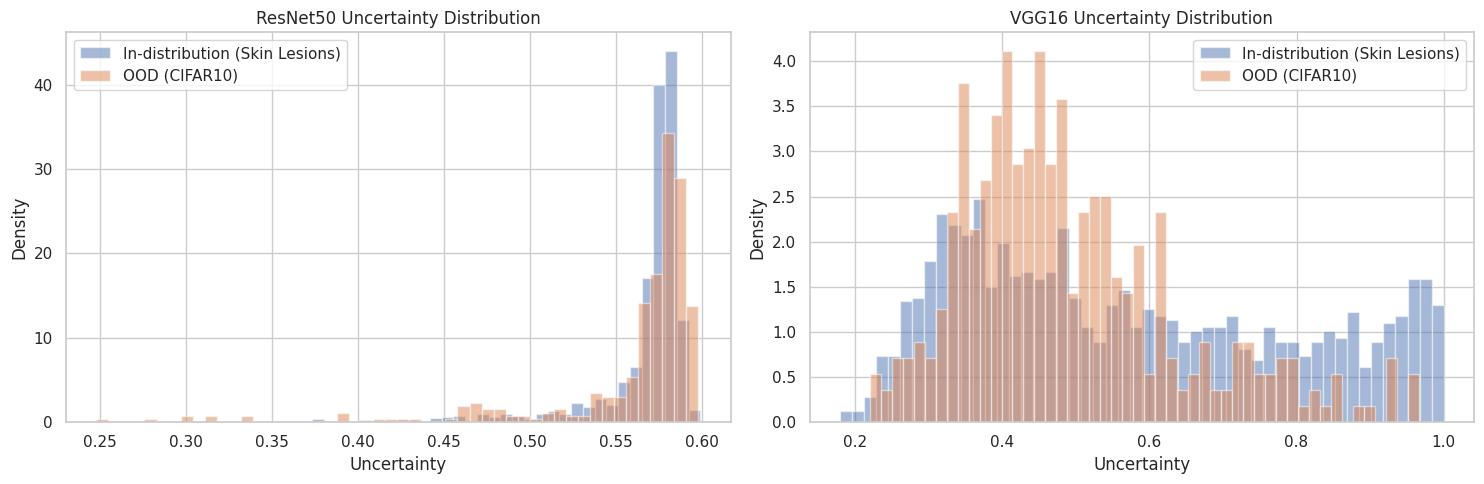

In [104]:
# Execute evaluation with desired ratio
main_ood_evaluation(edl_resnet50_model_focal, edl_vgg16_model_focal, ood_ratio=0.25)  


Loaded CIFAR10 OOD samples: 150 (ratio: 0.10)
Test set size: 1503

OOD Detection Metrics for ResNet50:
True Negative Rate (correct in-dist): 1.000
True Positive Rate (correct OOD): 0.000
AUROC: 0.558

Uncertainty Analysis:
Mean uncertainty for correct predictions (in-distribution): 0.578
Mean uncertainty for incorrect predictions(in-distribution): 0.565

OOD Detection Metrics for VGG16:
True Negative Rate (correct in-dist): 0.589
True Positive Rate (correct OOD): 0.147
AUROC: 0.401

Uncertainty Analysis:
Mean uncertainty for correct predictions (in-distribution): 0.511
Mean uncertainty for incorrect predictions(in-distribution): 0.753
Uncertainty distribution comparison in presence of OOD samples:



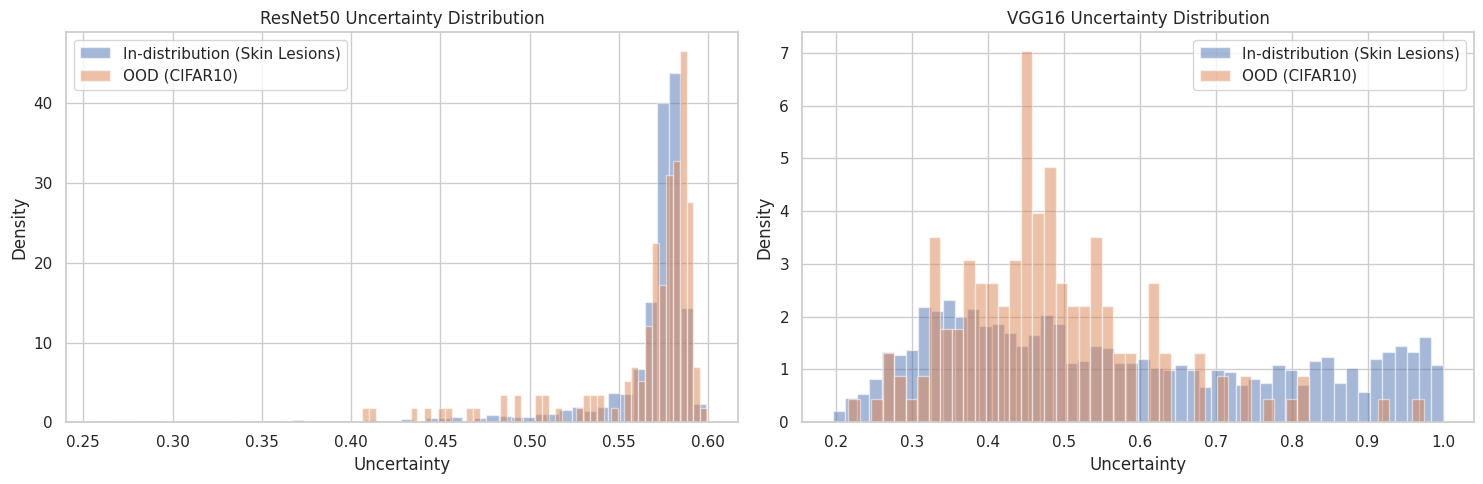

In [105]:
# Execute evaluation with desired ratio
main_ood_evaluation(edl_resnet50_model_focal, edl_vgg16_model_focal, ood_ratio=0.1)  